# **Maestría en Inteligencia Artificial Aplicada**

## **Opperaciones de aprendizaje automatico**

### Tecnológico de Monterrey
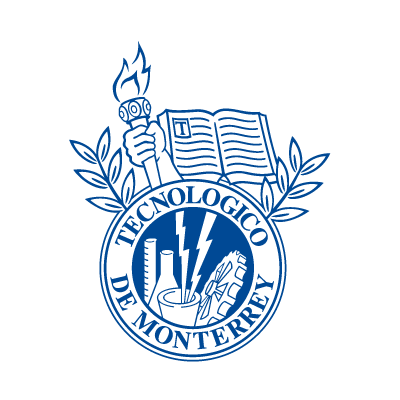

### Equipo 17

 Iván Nava Cardeño 

 Flavio César Palacios Salas

 Luis Enrique Gonzáles Gonzáles

 Fanny Betsabé Fuentes Reyes

 Emanuel Flores Martinez 



## EDA

El conjunto de datos proporcionado es del dataset Steel Industry Energy Consumption con aproximadamente 35,000 registros y 9 columnas.  La información recopilada proviene de DAEWOO Steel Co. Ltd. en Gwangyang, Corea del Sur. Produce diversos tipos de bobinas, placas de acero y placas de hierro. La información sobre el consumo eléctrico se almacena en un sistema en la nube. La información sobre el consumo energético de la industria se almacena en el sitio web de la Corporación de Energía Eléctrica de Corea y se calculan y muestran las perspectivas de los datos diarios, mensuales y anuales. El objetivo principal es predecir el consumo de energía en la industria del acero utilizando los diversos parametros dentro del conjunto de datos. El conjunto original no contiene valores nulos, así como los datos proporcionados no contienen valores extraños, sin embargo como parte de todo el flujo de trabajo, se proporcionó una base modificada la cuál si contiene datos faltantes y la cuál se tiene que limipiar y preparar para el modelado.

In [1]:
#Importación de librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon

In [2]:
#Funciones Auxiliares

def missing_percentage(df):
    """
    Calcula el porcentaje de valores faltantes en cada columna de un DataFrame
    """
    return (df.isna().sum() / len(df)) * 100

def describe2(df):
    """
    Genera un resumen estadístico extendido para las columnas numéricas de un DataFrame, con modificaciones sobre el método describe() de pandas.
    """
    # Solo columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Estadísticas básicas
    desc = df_numeric.describe()

    # Renombrar el cuartil 50% como "50% (Median)"
    desc.rename(index={'50%': '50% (Median)'}, inplace=True)

    # Agregar skewness y curtosis
    desc.loc['skew'] = df_numeric.skew()
    desc.loc['kurtosis'] = df_numeric.kurtosis()

    # Agregar todas las modas como string separados por coma
    mode_values = df_numeric.mode()
    mode_strs = []
    for col in df_numeric.columns:
        modes = mode_values[col].dropna().tolist()
        mode_str = ', '.join(map(str, modes))
        mode_strs.append(mode_str)
    desc.loc['mode'] = mode_strs

    # Reordenar filas: colocar 'mode' justo después de 'count'
    orden_deseado = ['count', 'mode'] + [i for i in desc.index if i not in ['count', 'mode']]
    desc = desc.loc[orden_deseado]

    # Transponer
    return desc.T

def barplots_for_categoricals(df, columns=None, n_cols=2, figsize_per_plot=(5, 4)):
    """
    Dibuja gráficos de barras para variables categóricas en un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        El DataFrame que contiene los datos.
    columns : list or None, opcional
        Lista de columnas a graficar. Si es None, se seleccionan automáticamente
        todas las columnas categóricas (object, category, bool).
    n_cols : int, opcional
        Número de columnas en el grid de subplots. Default=2.
    figsize_per_plot : tuple, opcional
        Tamaño de cada gráfico individual (ancho, alto). Default=(5, 4).
    """

    # Selección de columnas
    if columns is not None:
        cat_cols = [col for col in columns if col in df.columns]
        if not cat_cols:
            print("No matching columns found in DataFrame.")
            return
    else:
        df_cat = df.select_dtypes(include=['object', 'category', 'bool'])
        cat_cols = df_cat.columns.tolist()

    num_plots = len(cat_cols)
    if num_plots == 0:
        print("No categorical variables found.")
        return

    # Calcular número de filas
    n_rows = math.ceil(num_plots / n_cols)

    # Crear subplots
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * figsize_per_plot[0], n_rows * figsize_per_plot[1])
    )
    axes = axes.flatten()

    # Iterar columnas categóricas
    for i, col in enumerate(cat_cols):
        ax = axes[i]
        counts = df[col].value_counts(dropna=False)
        bars = ax.bar(counts.index.astype(str), counts.values, color='skyblue')

        # Títulos y etiquetas
        ax.set_title(col)
        ax.set_ylabel('Count')
        ax.set_xticks(range(len(counts.index)))
        ax.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')

        # Padding en Y
        max_height = max(counts.values)
        ax.set_ylim(0, max_height * 1.10)

        # Anotar valores en las barras
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Ocultar subplots no usados
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle('Gráficas de barra para variables categoricas', fontsize=20)
    plt.tight_layout()
    plt.show()


def save_df_to_csv(df, filename, sep=",", index=False, encoding="utf-8", date_cols=None):
    """
    Guarda un DataFrame en un archivo CSV con formato de fecha DD/MM/YYYY HH:MM (sin segundos).

    Parámetros
    ----------
    df : pandas.DataFrame
        El DataFrame a guardar.
    filename : str
        Nombre (y ruta opcional) del archivo de salida.
    sep : str, opcional
        Separador de columnas. Default=",".
    index : bool, opcional
        Incluir índice en el CSV. Default=False.
    encoding : str, opcional
        Codificación. Default="utf-8".
    date_cols : list or None
        Lista de columnas de tipo fecha a formatear como "DD/MM/YYYY HH:MM".
        Si None, no se formatea ninguna.
    """
    df_copy = df.copy()

    if date_cols is not None:
        for col in date_cols:
            if col in df_copy.columns and pd.api.types.is_datetime64_any_dtype(df_copy[col]):
                df_copy[col] = df_copy[col].dt.strftime("%d/%m/%Y %H:%M")

    try:
        df_copy.to_csv(filename, sep=sep, index=index, encoding=encoding)
        print(f"✅ DataFrame guardado exitosamente en: {filename}")
    except Exception as e:
        print(f"❌ Error al guardar el DataFrame: {e}")

def plot_hist(df, n_cols=4, log =False):
    # Solo columnas numéricas
    df_numeric = df.select_dtypes(include='number')
    num_plots = len(df_numeric.columns)

    # Calcular filas necesarias
    n_rows = math.ceil(num_plots / n_cols)

    # Crear subplots (ajusta el número de filas/columnas según lo que necesites)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axes = axes.flatten()

    # Generar histograma por cada columna
    for ax, col in zip(axes, df_numeric.columns):
        sns.histplot(data=df_numeric[col].dropna(), ax=ax, kde=False, bins=30, log = log)
        ax.set_title(f'{col}')
        ax.set_xlabel("Valor")
        ax.set_ylabel("Frecuencia")
        ax.grid(True)
    
    # Ocultar subplots vacíos si los hay
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)
    if log == True:
        fig.suptitle('Histogramas de las variables númericas (Escala Logarítmica)', fontsize=20)
    else: 
        fig.suptitle('Histograma de las variables númericas', fontsize=20)
    plt.tight_layout()
    plt.show()


def boxplots(df, n_cols=4, figsize_per_plot=(4, 4), y = None, hue = None):
    # Seleccionar columnas numéricas
    df_numeric = df.select_dtypes(include='number')
    num_plots = len(df_numeric.columns)

    # Calcular filas necesarias
    n_rows = math.ceil(num_plots / n_cols)

    # Crear figura y subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * figsize_per_plot[0], n_rows * figsize_per_plot[1]))
    axes = axes.flatten()  # Para indexar fácilmente, aunque sea 1D

    for i, col in enumerate(df_numeric.columns):
        ax = axes[i]
        sns.boxplot(data=df, x = col, ax=ax, orient= 'h', y = y, hue = hue)
        ax.set_title(f'{col}')
        ax.grid(True)

    # Ocultar subplots vacíos si los hay
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle('Box-Plot de las variables númericas', fontsize=20)

    plt.tight_layout()
    plt.show()

def plot_kde_hist(df, hue = None, n_cols=4):
    """"
    Dibuja gráficos KDE para variables numéricas en un DataFrame, con opción de agrupar por una variable categórica.
    """
    # Solo columnas numéricas
    df_numeric = df.select_dtypes(include='number')
    num_plots = len(df_numeric.columns)

    # Calcular filas necesarias
    n_rows = math.ceil(num_plots / n_cols)

    # Crear subplots (ajusta el número de filas/columnas según lo que necesites)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 8))
    axes = axes.flatten() 

    fig.suptitle('Comparación de la Distribución KDE de las variables númericas', fontsize=20)
    # Generar gráfico KDE por cada columna
    for ax, col in zip(axes, df_numeric.columns):
        sns.kdeplot(data=df, x = col,hue=hue, ax=ax, fill=True )
        ax.set_title(f'{col}')
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.grid(True)

     # Ocultar subplots vacíos si los hay
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()



def drop_outliers_iqr_global(df, col, k=1.5, return_mask=False):
    """Elimina outliers de `col` con IQR global (sin agrupar)."""
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    mask = df[col].isna() | df[col].between(lo, hi)
    if return_mask:
        return mask, (lo, hi)
    return df[mask].copy(), (lo, hi)

def drop_outliers_iqr_grouped(df, cols, k):
    "Elimina outliers en múltiples columnas usando IQR global."

    for n in range(len(cols)):
        len_df = len(df)
        df, (lo, hi) = drop_outliers_iqr_global(df, cols[n], k[n])
        print(f'Dropped outliers in {cols[n]}: kept values between {lo:.2f} and {hi:.2f}')
        print(len_df, '→', len(df), 'rows')
    return df


def wassertein_comparison(df, dt1_name = 'Original', dt2_name = 'Modified', hue_col='Dataset'):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    dataset1 = df[df[hue_col] == dt1_name]
    dataset2 = df[df[hue_col] == dt2_name]

    distances = {}
    for col in numeric_cols:
        dist = wasserstein_distance(dataset1[col].dropna(), dataset2[col].dropna())
        distances[col] = dist

    distances_df = pd.DataFrame.from_dict(distances, orient='index', columns=['Wasserstein Distance'])
    distances_df.sort_values(by='Wasserstein Distance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=distances_df.index, y='Wasserstein Distance', data=distances_df, palette='BuGn_d', hue = distances_df.index)
    plt.xticks(rotation=45, ha='right')
    plt.title('Distancia de Wasserstein', fontsize = 20)
    plt.ylabel('Distancia de Wasserstein')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

    return distances_df

def jensen_shannon_comparison(df, dt1_name = 'Original', dt2_name = 'Modified', hue_col='Dataset', bins=30):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    dataset1 = df[df[hue_col] == dt1_name]
    dataset2 = df[df[hue_col] == dt2_name]

    distances = {}
    for col in numeric_cols:
        hist1, bin_edges = np.histogram(dataset1[col].dropna(), bins=bins, density=True)
        hist2, _ = np.histogram(dataset2[col].dropna(), bins=bin_edges, density=True)
        hist1 += 1e-10
        hist2 += 1e-10
        dist = jensenshannon(hist1, hist2)
        distances[col] = dist

    distances_df = pd.DataFrame.from_dict(distances, orient='index', columns=['Distancia de Jensen-Shannon'])
    distances_df.sort_values(by='Distancia de Jensen-Shannon', ascending=False, inplace=True)
    distances_df['Distancia de Jensen-Shannon'] = distances_df['Distancia de Jensen-Shannon'].round(3)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=distances_df.index, y='Distancia de Jensen-Shannon', data=distances_df, palette='BuGn_d', hue = distances_df.index )
    plt.xticks(rotation=45, ha='right')
    plt.title('Distancia de Jensen-Shannon', fontsize = 20)
    plt.ylabel('Distancia de Jensen-Shannon ')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

    return distances_df

# Carga de los datos

In [3]:
df = pd.read_csv('data/raw/steel_energy_modified.csv')

In [4]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.0,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.5,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


In [5]:
df2 = df.copy()

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35740 entries, 0 to 35739
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   date                                  35401 non-null  object
 1   Usage_kWh                             35339 non-null  object
 2   Lagging_Current_Reactive.Power_kVarh  35339 non-null  object
 3   Leading_Current_Reactive_Power_kVarh  35327 non-null  object
 4   CO2(tCO2)                             35370 non-null  object
 5   Lagging_Current_Power_Factor          35291 non-null  object
 6   Leading_Current_Power_Factor          35338 non-null  object
 7   NSM                                   35325 non-null  object
 8   WeekStatus                            35400 non-null  object
 9   Day_of_week                           35428 non-null  object
 10  Load_Type                             35432 non-null  object
 11  mixed_type_col              

Podemos observar que de toda las columnas, la mayoría de estás son númericas, sin embargo también contamos con un par de columnas categóricas, por lo que necesitaremos tratarlas de manera diferente y entender su comportamiento

# Variables númericas

In [7]:
# Convertir la columna 'date'a datetime
df2['date'] = pd.to_datetime(df['date'].str.strip(), format='%d/%m/%Y %H:%M', errors='raise')

In [8]:
#seleccionar las columnas númericas
numeric_cols = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']

for col in numeric_cols:
    df2[col] = pd.to_numeric(df2[col].replace(['invalid', '?', 'error', ' NAN ', ' ? ', ' null ', ' ERROR ', ' n/a ', ' INVALID '], np.nan), errors='coerce')

In [9]:
df2

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:15:00,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.00,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.00,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.00,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.00,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325
...,...,...,...,...,...,...,...,...,...,...,...,...
35735,2018-06-06 02:15:00,3.60,5.00,0.0,0.00,58.43,100.0,8100.0,Weekday,Wednesday,Light_Load,bad
35736,2018-02-11 02:45:00,3.89,4.00,0.0,0.00,69.72,100.0,9900.0,Weekend,Sunday,lIGHT_lOAD,bad
35737,2018-02-20 04:30:00,5.83,5.22,0.0,0.00,74.50,100.0,16200.0,Weekday,Tuesday,Light_Load,674
35738,2018-01-31 13:45:00,123.88,44.75,0.0,0.06,94.05,100.0,49500.0,Weekday,Wednesday,Medium_Load,206


In [10]:
df2.drop(columns=['mixed_type_col'], inplace=True)

In [11]:
df2['NSM'] = df2['NSM'].astype('Int64')

In [12]:
# Investigar valores faltantes
missing_percentage(df2)

date                                    1.012871
Usage_kWh                               1.443760
Lagging_Current_Reactive.Power_kVarh    1.482932
Leading_Current_Reactive_Power_kVarh    1.550084
CO2(tCO2)                               1.426973
Lagging_Current_Power_Factor            1.600448
Leading_Current_Power_Factor            1.471740
NSM                                     1.552882
WeekStatus                              0.951315
Day_of_week                             0.872971
Load_Type                               0.861780
dtype: float64

In [13]:
describe2(df2)

,count,mode,mean,std,min,25%,50% (Median),75%,max,skew,kurtosis
Usage_kWh,35224.0,3.06,39.400143,276.516063,0.0,3.24,4.61,52.06,34899.48,69.11708,7524.39692
Lagging_Current_Reactive.Power_kVarh,35210.0,0.0,18.734507,89.876721,0.0,2.3,5.0,23.33,6145.92,27.717697,1189.081346
Leading_Current_Reactive_Power_kVarh,35186.0,0.0,7.617218,55.10866,0.0,0.0,0.0,2.59,2301.84,17.898318,405.018552
CO2(tCO2),35230.0,0.0,2.635854,41.636508,0.0,0.0,0.0,0.02,1364.04,17.900662,347.297603
Lagging_Current_Power_Factor,35168.0,100.0,101.634809,316.378288,0.0,63.55,88.21,99.46,9900.0,19.363849,416.491967
Leading_Current_Power_Factor,35214.0,100.0,109.390282,371.783664,0.0,99.7225,100.0,100.0,9800.0,18.568826,377.421001
NSM,35185.0,"75600, 79200",52646.198664,192885.357686,0.0,21600.0,43200.0,64800.0,7783200.0,24.137984,681.616311


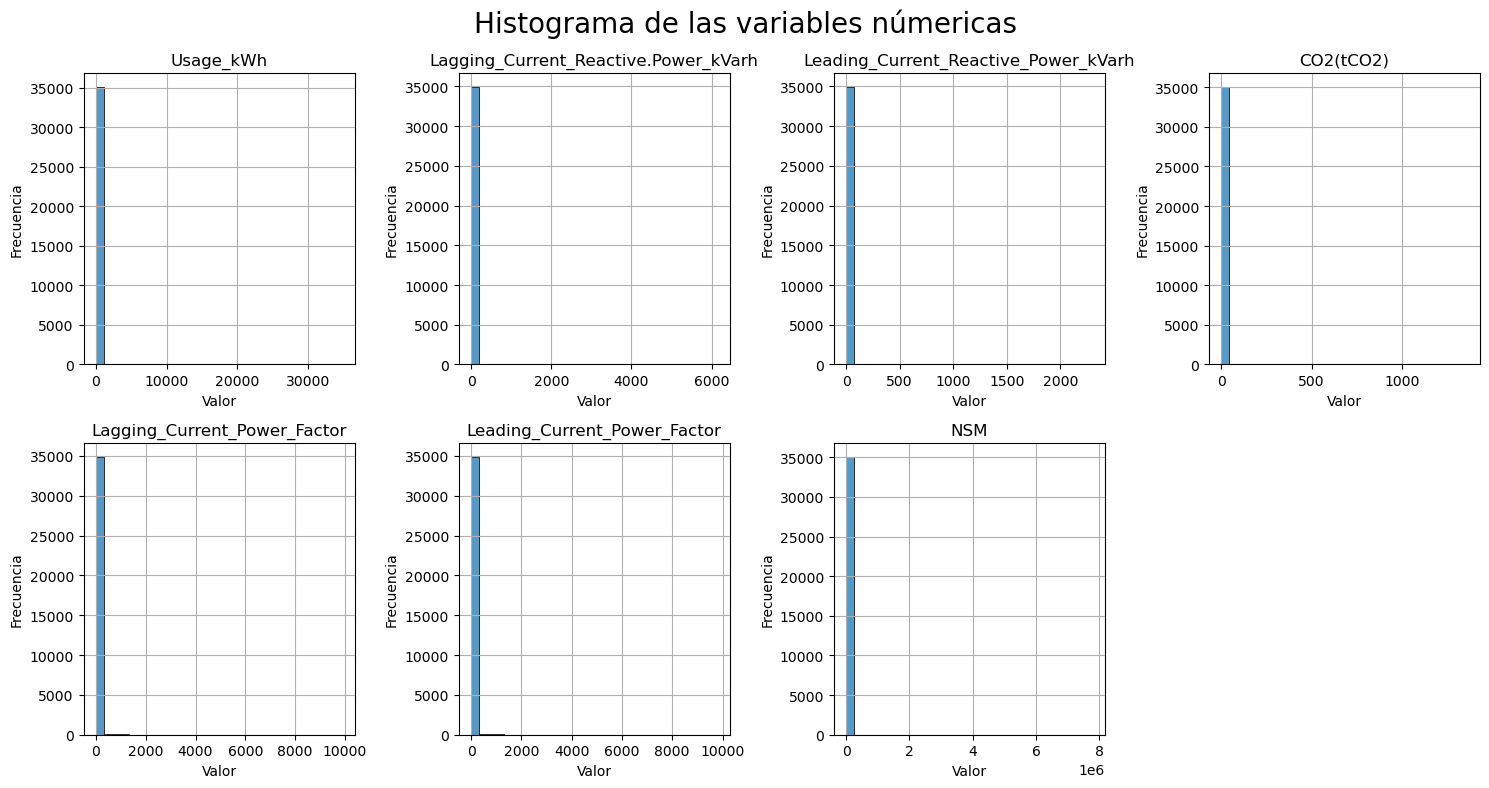

In [14]:
plot_hist(df2, log  =False)

Podemos observar que las variables númericas tienen una distribución asimétrica a la derecha, los datos estan concentrados y no podemos ver el comportamiento de cada una de las variables, por ello se recomienda aplicar una transformación logarítmica para entender los datos así como para considerarlo en los modelos y mejorar el rendimiento en el caso de los modelos que se pudieran ver afectados por la asimetría de los datos.

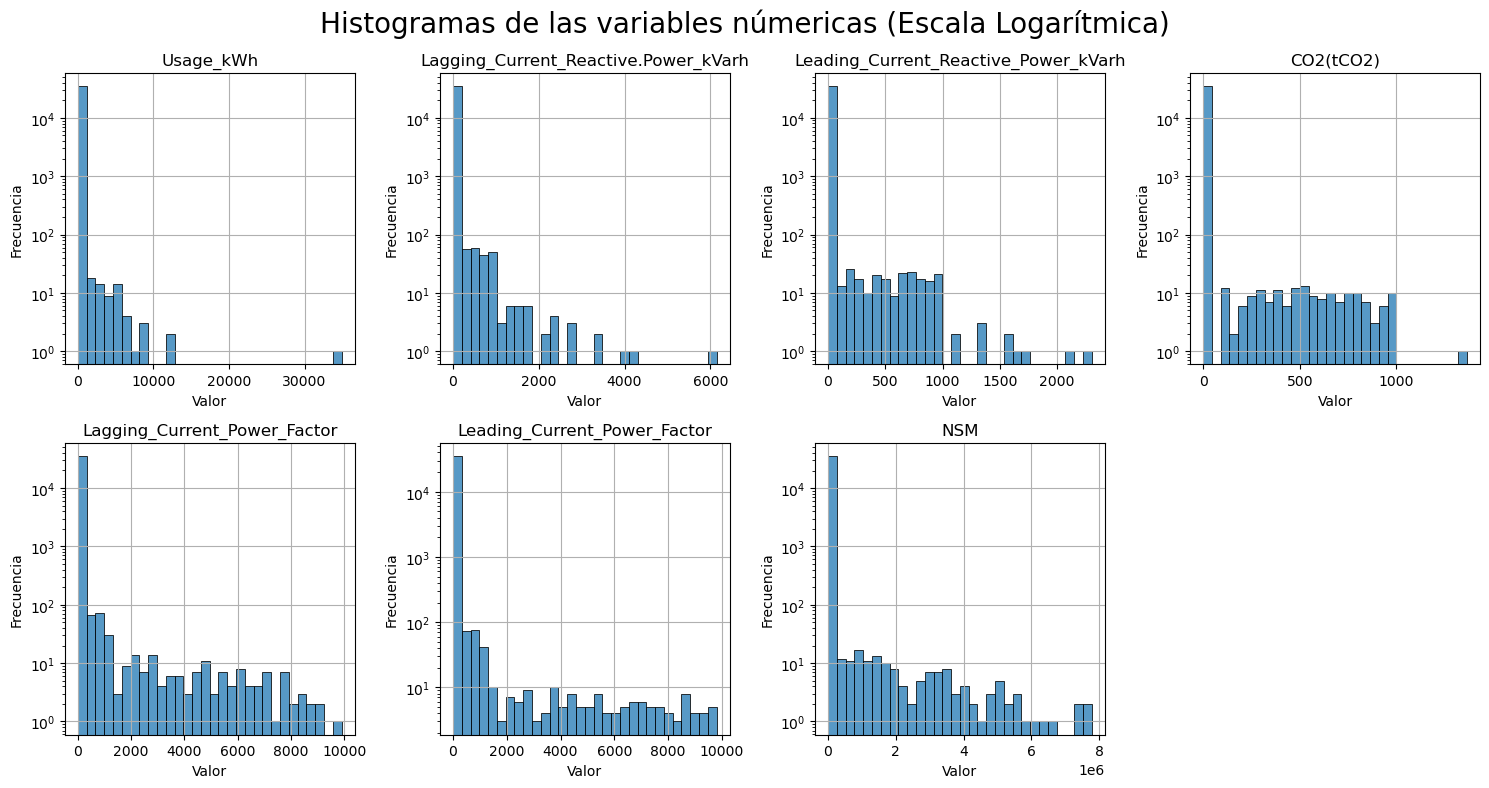

In [15]:
plot_hist(df2,n_cols=4, log  =True)

Después de aplicar la transformación logarítmica, podemos observar mejor el comportamiento de las variables númericas, ya que los datos se encuentran más distribuidos y podemos observar mejor la distribución de los datos. A pesar de ello las variables presentan una ligera asimetría aunque menos marcada que antes de la transformación

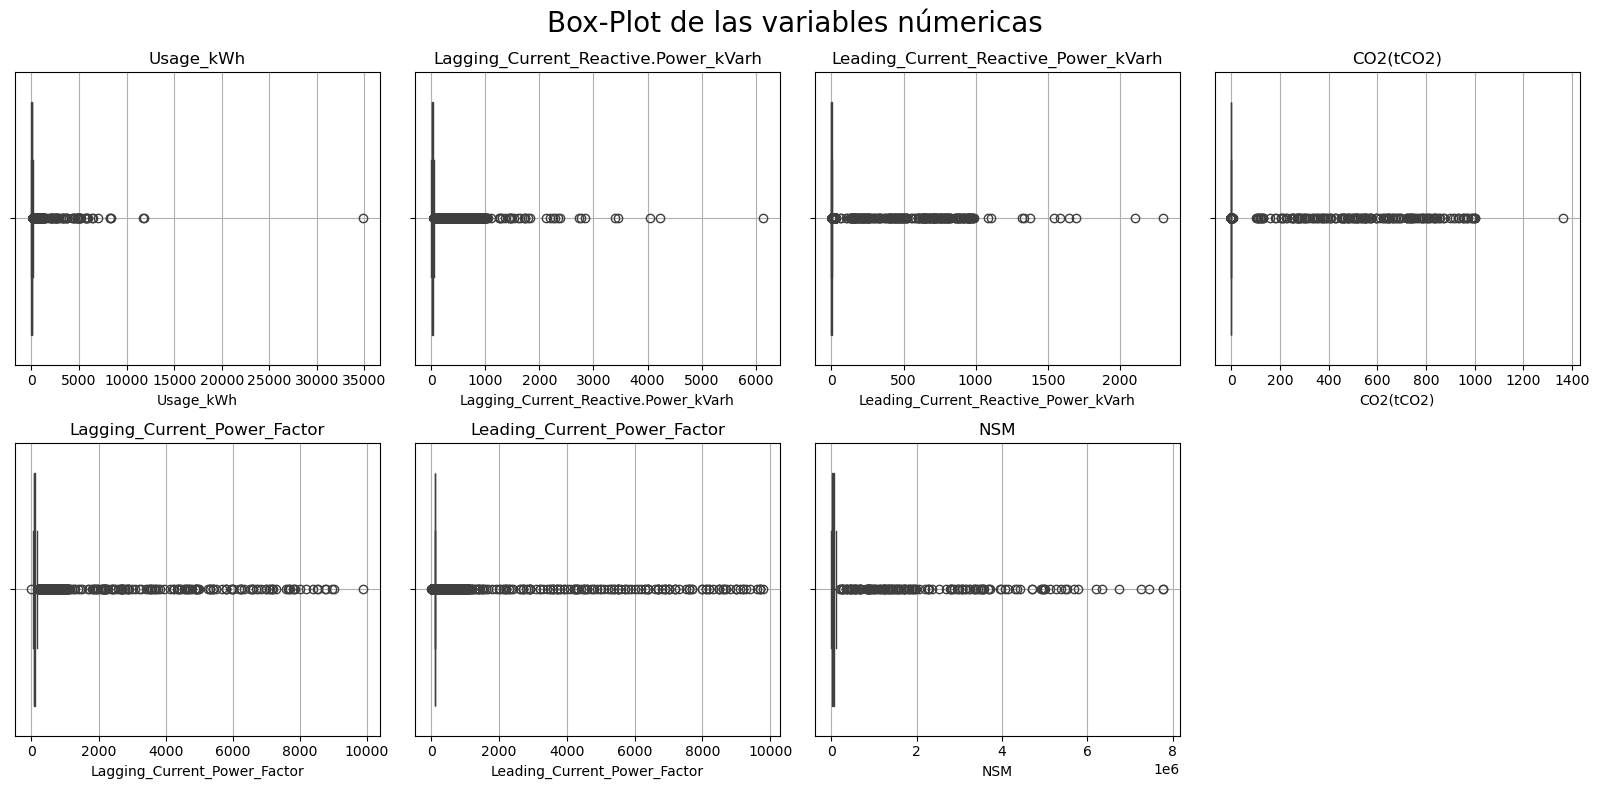

In [16]:
boxplots(df2)

Podemos observar la presencia de muchos outliers en las variables númericas, lo cual puede afectar el rendimiento de los modelos, por lo que vamos a aplicar una técnica para eliminar los outliers

# Variables categóricas

Sabemos por el ejercicio que todo el conjunto de datos esta ensuciado, con lo que, tenemos que verificar en las variables categoricas si existen valores faltantes o si no estan estandarizados los valores con cambios de letras, combinación de mayusculas y minisculas, etc.

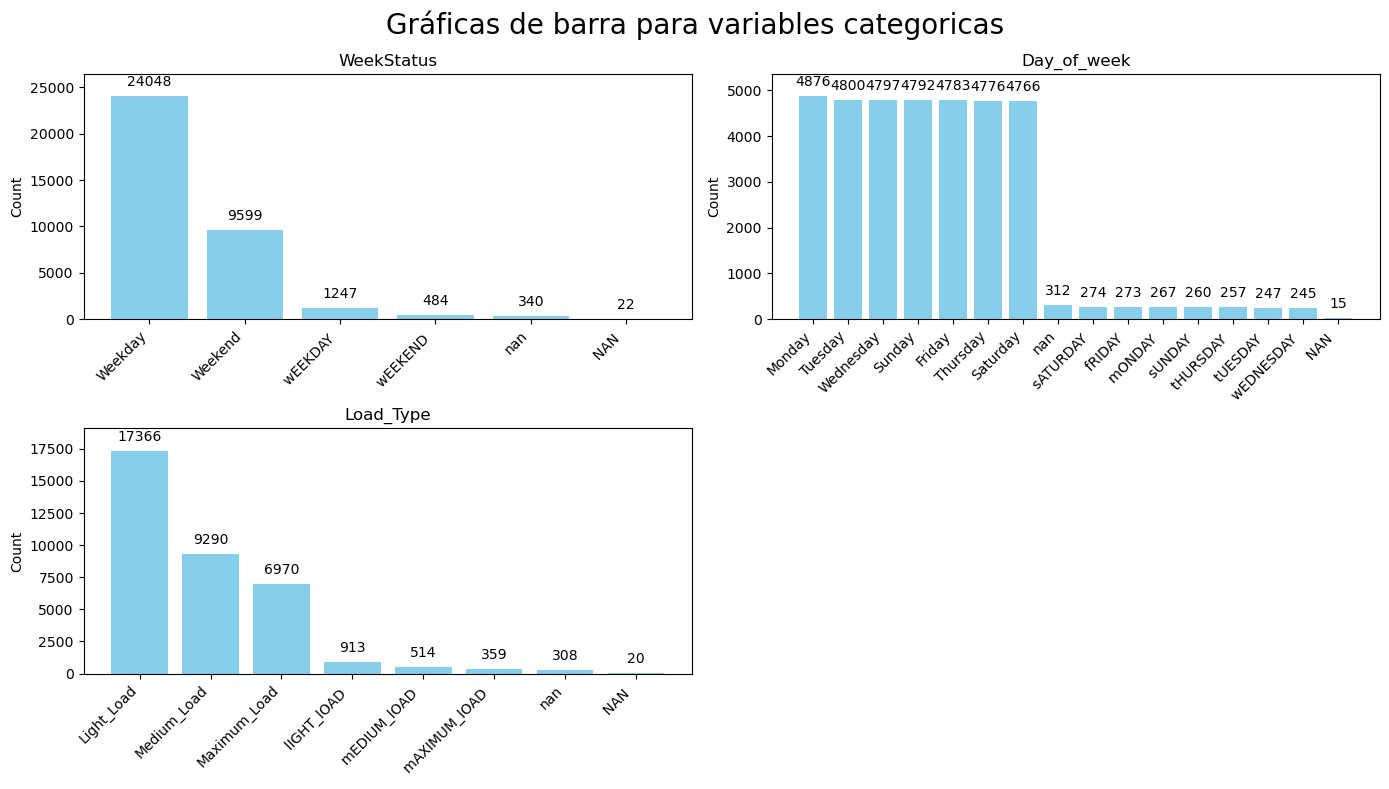

In [17]:
barplots_for_categoricals(df2, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], n_cols=2, figsize_per_plot=(7, 4))

Como podemos ver en las gráficas de barras, la hipotesis se confirma, con lo que, tenemos que limpiar los datos para estandarizar los valores y eliminar los valores faltantes.

In [18]:
weekday_mapping = {
    'wEEKDAY':'Weekday',
    'wEEKEND':'Weekend',
    'NAN' : np.nan
}
df2['WeekStatus'] = df2['WeekStatus'].str.strip().replace(weekday_mapping)

day_of_week_mapping = {
    'mONDAY': 'Monday',
    'tUESDAY': 'Tuesday',
    'wEDNESDAY': 'Wednesday',
    'tHURSDAY': 'Thursday',
    'fRIDAY': 'Friday',
    'sATURDAY': 'Saturday',
    'sUNDAY': 'Sunday',
    'NAN' : np.nan
}
df2['Day_of_week'] = df2['Day_of_week'].str.strip().replace(day_of_week_mapping)

load_type_mapping = {
    'lIGHT_lOAD': 'Light_Load',
    'mEDIUM_lOAD': 'Medium_Load',
    'mAXIMUM_lOAD': 'Maximum_Load',
    'NAN' : np.nan
}
df2['Load_Type'] = df2['Load_Type'].str.strip().replace(load_type_mapping)

In [19]:
df2.describe(include='object').T

,count,unique,top,freq
WeekStatus,35378,2,Weekday,25295
Day_of_week,35413,7,Monday,5143
Load_Type,35412,3,Light_Load,18279


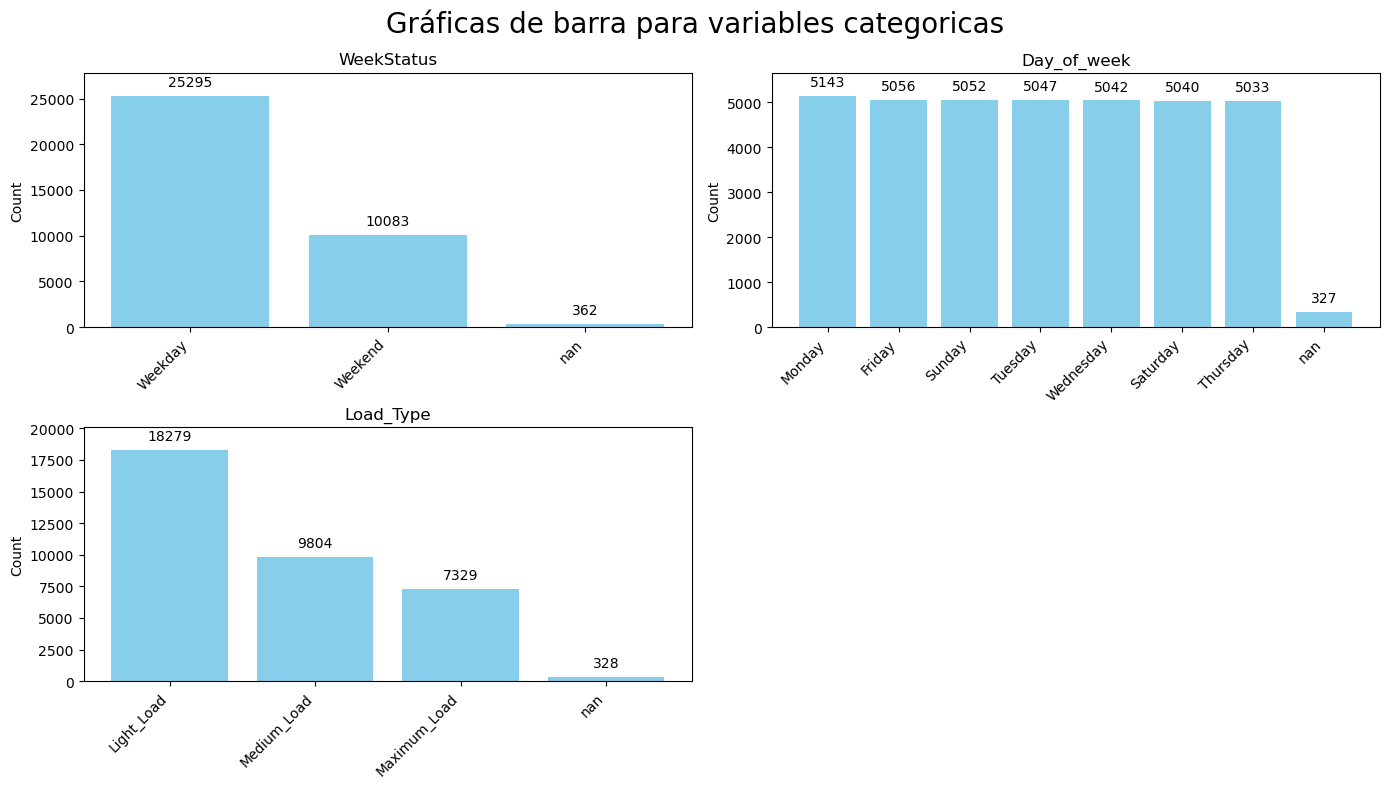

In [20]:
# Variables categoricas 
barplots_for_categoricals(df2, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], n_cols=2, figsize_per_plot=(7, 4))

Hasta este punto hemos limpiado las variables categoricas, sin embargo tenemos que eliminar todavía los valores faltantes, para ahora si tener un dataframe limpio y que se aproxime al dataset original

In [21]:
df2.dropna(inplace=True)

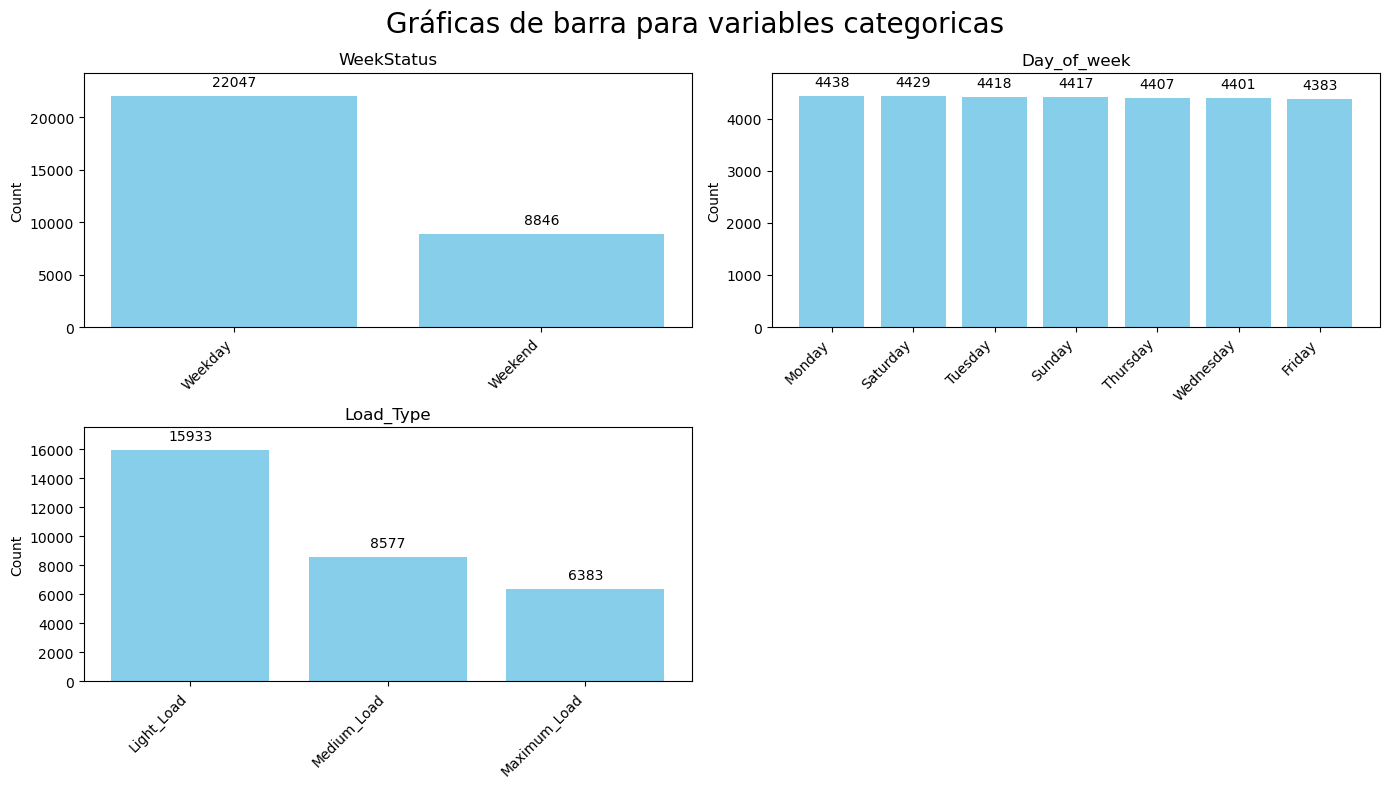

In [22]:
# Variables categoricas 
barplots_for_categoricals(df2, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], n_cols=2, figsize_per_plot=(7, 4))

In [23]:
#descripción del dataframe limpio
df3 = df2.copy()
df3.describe().T

,count,mean,min,25%,50%,75%,max,std
date,30893,2018-07-02 14:35:23.840352,2018-01-01 00:00:00,2018-04-02 09:45:00,2018-07-03 00:30:00,2018-10-01 10:30:00,2018-12-31 23:45:00,NaN
Usage_kWh,30893.0,39.071902,0.0,3.2,4.61,51.95,34899.48,277.400822
Lagging_Current_Reactive.Power_kVarh,30893.0,18.923536,0.0,2.3,5.0,23.26,6145.92,92.83852
Leading_Current_Reactive_Power_kVarh,30893.0,7.645775,0.0,0.0,0.0,2.84,2301.84,54.933491
CO2(tCO2),30893.0,2.622052,0.0,0.0,0.0,0.02,1364.04,41.650244
Lagging_Current_Power_Factor,30893.0,101.584837,0.0,63.56,88.23,99.51,9900.0,315.866971
Leading_Current_Power_Factor,30893.0,108.796659,0.0,99.7,100.0,100.0,9800.0,365.291313
NSM,30893.0,52021.013077,0.0,21600.0,43200.0,64800.0,7783200.0,186382.917253


In [24]:
df_original = pd.read_csv('data/raw/steel_energy_original.csv')

In [25]:
df_original['Dataset'] = "Original"
df3['Dataset'] = "Modified"
combined_df = pd.concat([df_original, df3], ignore_index=True)

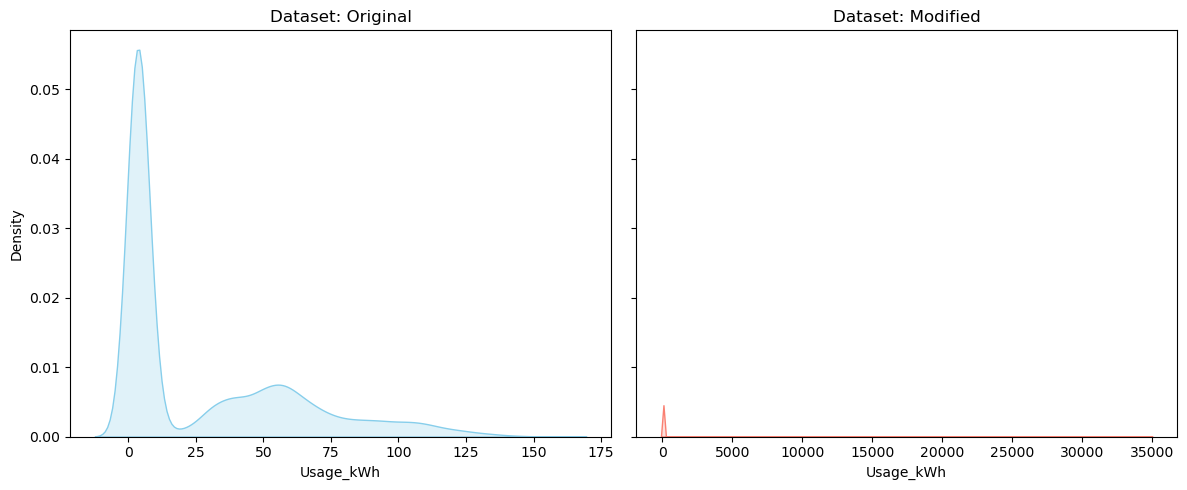

In [26]:
# Comparación de distribuciones de 'Usage_kWh' entre los dos datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  

# Subplot 1: Dataset = Original
sns.kdeplot(
    data=combined_df[combined_df['Dataset'] == 'Original'],
    x='Usage_kWh',
    fill=True,
    ax=axes[0],
    color='skyblue'
)
axes[0].set_title('Dataset: Original')

# Subplot 2: Dataset = Modified
sns.kdeplot(
    data=combined_df[combined_df['Dataset'] == 'Modified'],
    x='Usage_kWh',
    fill=True,
    ax=axes[1],
    color='salmon'
)
axes[1].set_title('Dataset: Modified')

plt.tight_layout()
plt.show()

Como se puede observar, las distribuciones de los dataframes no son similares, esto debido a que como observamos el conjunto de datos modificados presenta una gran cantidad de outliers (visto anteriormente en las gráficas boxplot) que hace que ambas distribuciones no se parezcan, por lo que tendremos que eliminarlos y obtener un conjunto de datos limpio y que se asemeje al conjunto de datos original

In [27]:
# eliminación de outliers
df3_without_o = drop_outliers_iqr_grouped(df3, numeric_cols[:-1], [2,4,20,1.5,3,300])

Dropped outliers in Usage_kWh: kept values between -94.30 and 149.45
30893 → 30603 rows
Dropped outliers in Lagging_Current_Reactive.Power_kVarh: kept values between -81.09 and 106.47
30603 → 30346 rows
Dropped outliers in Leading_Current_Reactive_Power_kVarh: kept values between -59.80 and 62.79
30346 → 30153 rows
Dropped outliers in CO2(tCO2): kept values between -0.03 and 0.05
30153 → 29580 rows
Dropped outliers in Lagging_Current_Power_Factor: kept values between -46.58 and 209.41
29580 → 29299 rows
Dropped outliers in Leading_Current_Power_Factor: kept values between -17.39 and 217.00
29299 → 29007 rows


In [28]:
len_previous = len(df3_without_o)
df3_without_o = df3_without_o[df3_without_o['NSM'] <= 85500]
print(len_previous, '→', len(df3_without_o), 'rows')

29007 → 28886 rows


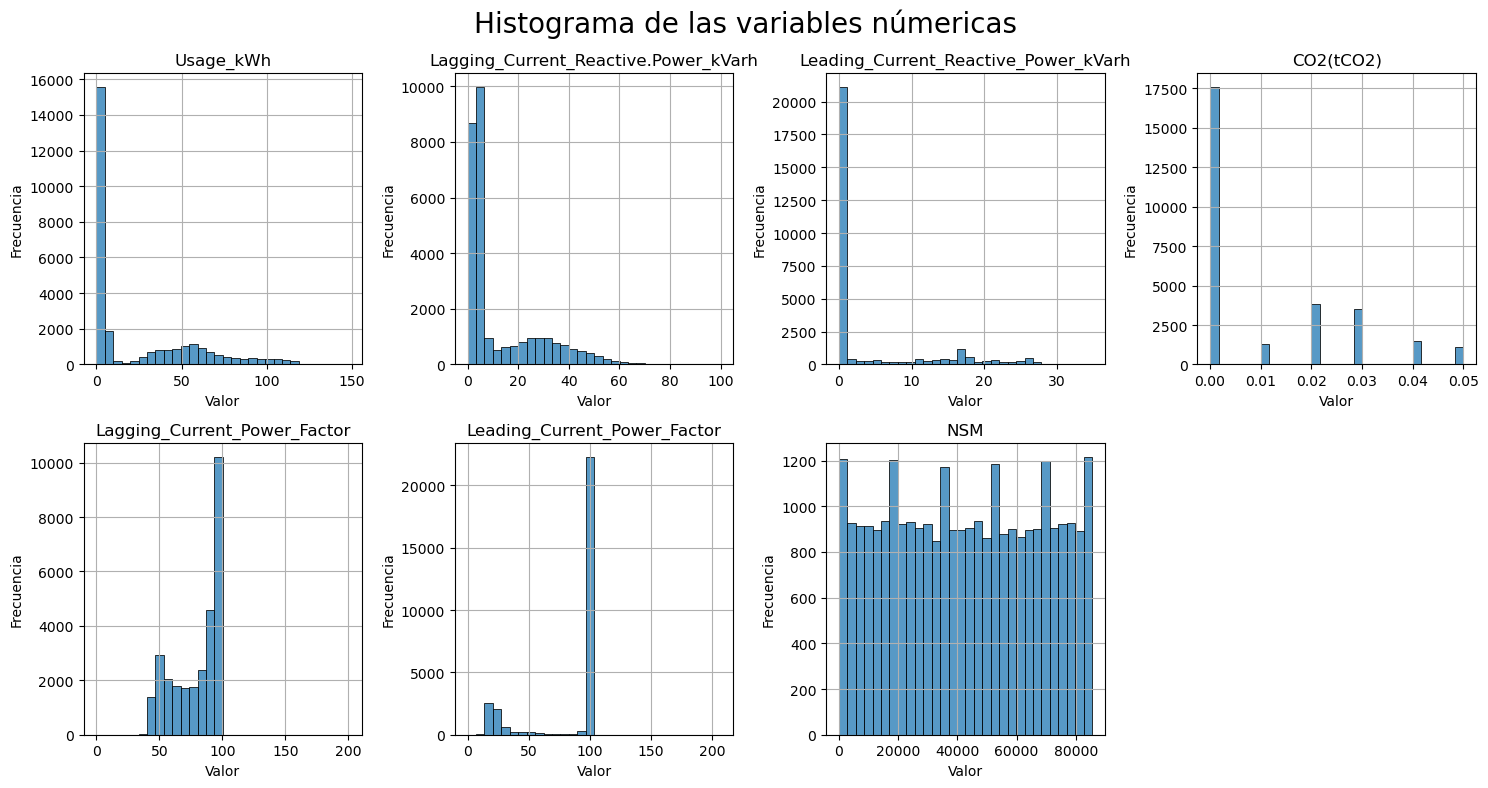

In [29]:
# Histograma sin outliers
plot_hist(df3_without_o,n_cols=4, log  =False)

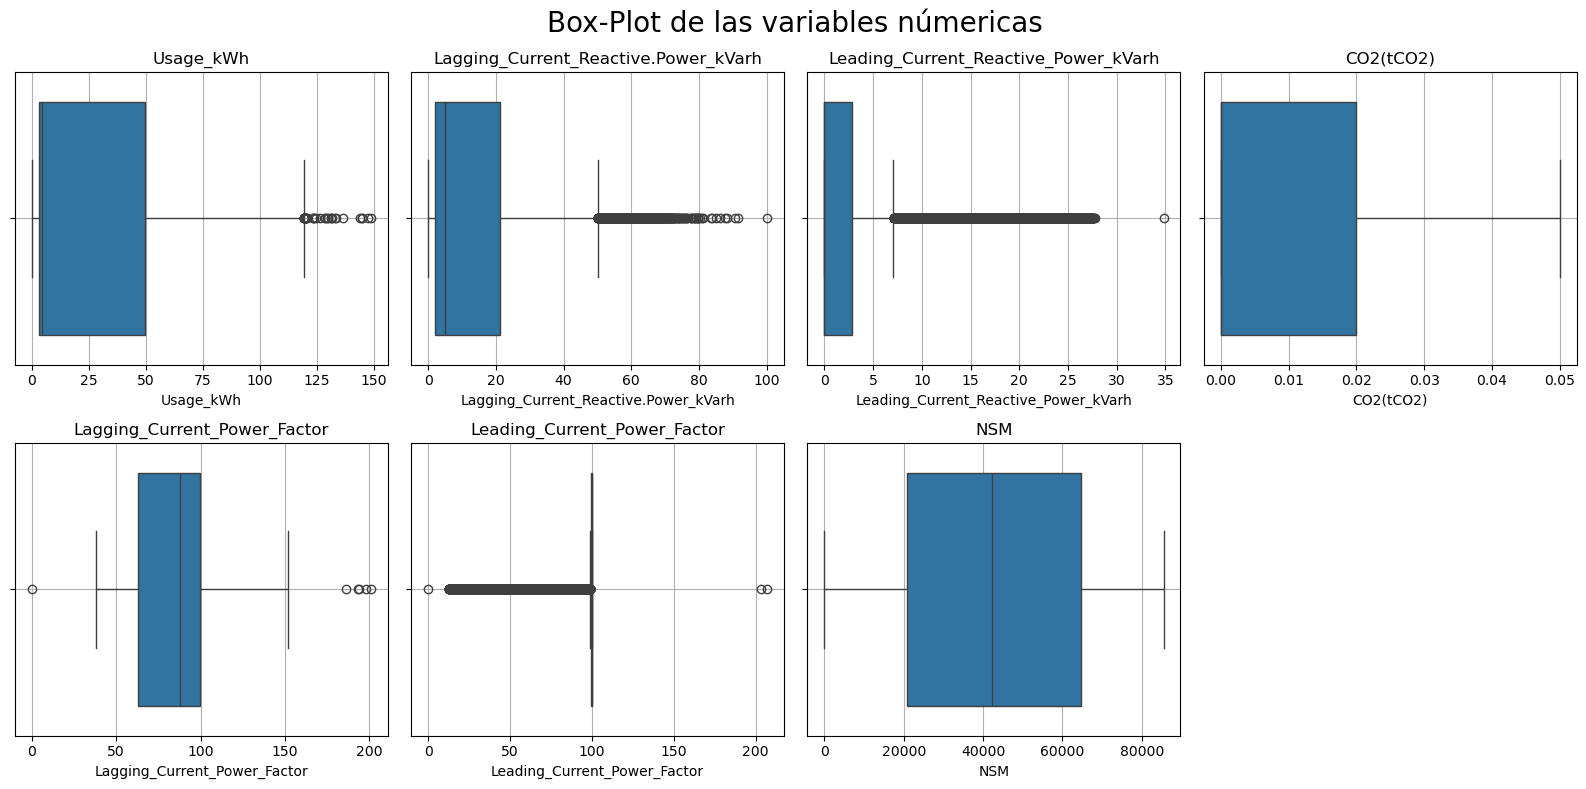

In [30]:
# Boxplot sin outliers
boxplots(df3_without_o)

In [31]:
# Copia del dataframe sin outliers
df4 = df3_without_o.copy()

In [32]:
# Nuevo dataset combinado sin outliers
combined_df2 = pd.concat([df_original, df4], ignore_index=True)

In [33]:
combined_df2

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Dataset
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load,Original
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load,Original
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load,Original
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load,Original
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load,Original
...,...,...,...,...,...,...,...,...,...,...,...,...
63921,2018-05-13 20:45:00,3.20,0.00,16.92,0.0,100.00,18.58,74700,Weekend,Sunday,Light_Load,Modified
63922,2018-06-06 02:15:00,3.60,5.00,0.00,0.0,58.43,100.00,8100,Weekday,Wednesday,Light_Load,Modified
63923,2018-02-11 02:45:00,3.89,4.00,0.00,0.0,69.72,100.00,9900,Weekend,Sunday,Light_Load,Modified
63924,2018-02-20 04:30:00,5.83,5.22,0.00,0.0,74.50,100.00,16200,Weekday,Tuesday,Light_Load,Modified


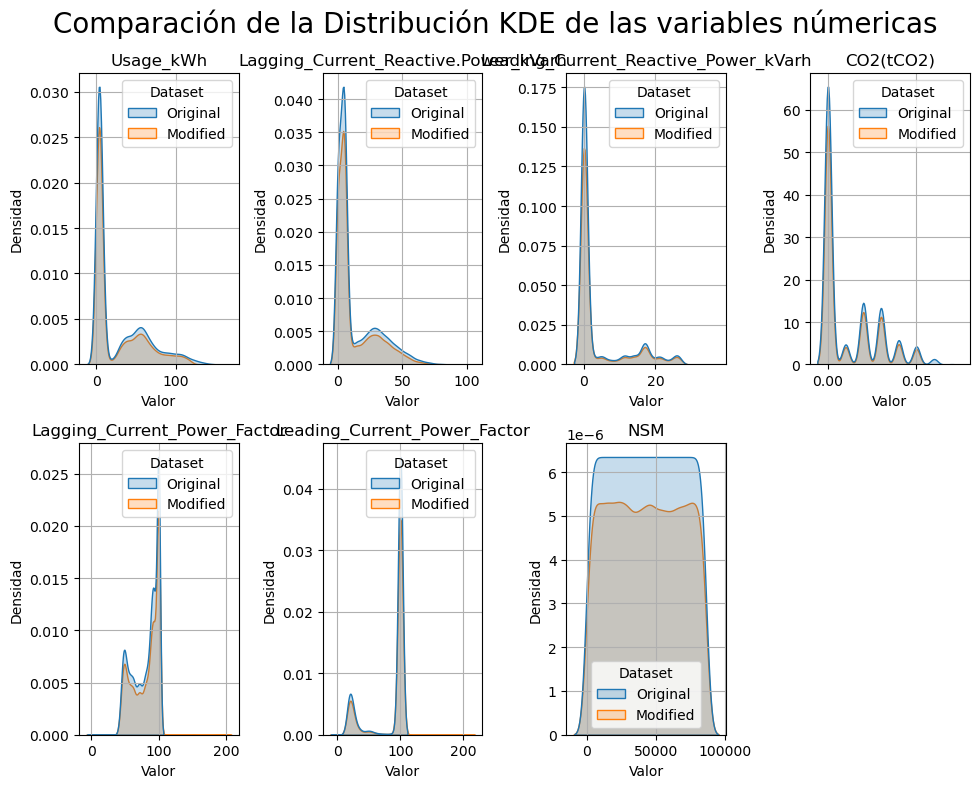

In [34]:
# Comparación de distribuciones entre los dos datasets sin outliers
plot_kde_hist(combined_df2, hue = 'Dataset', n_cols=4)

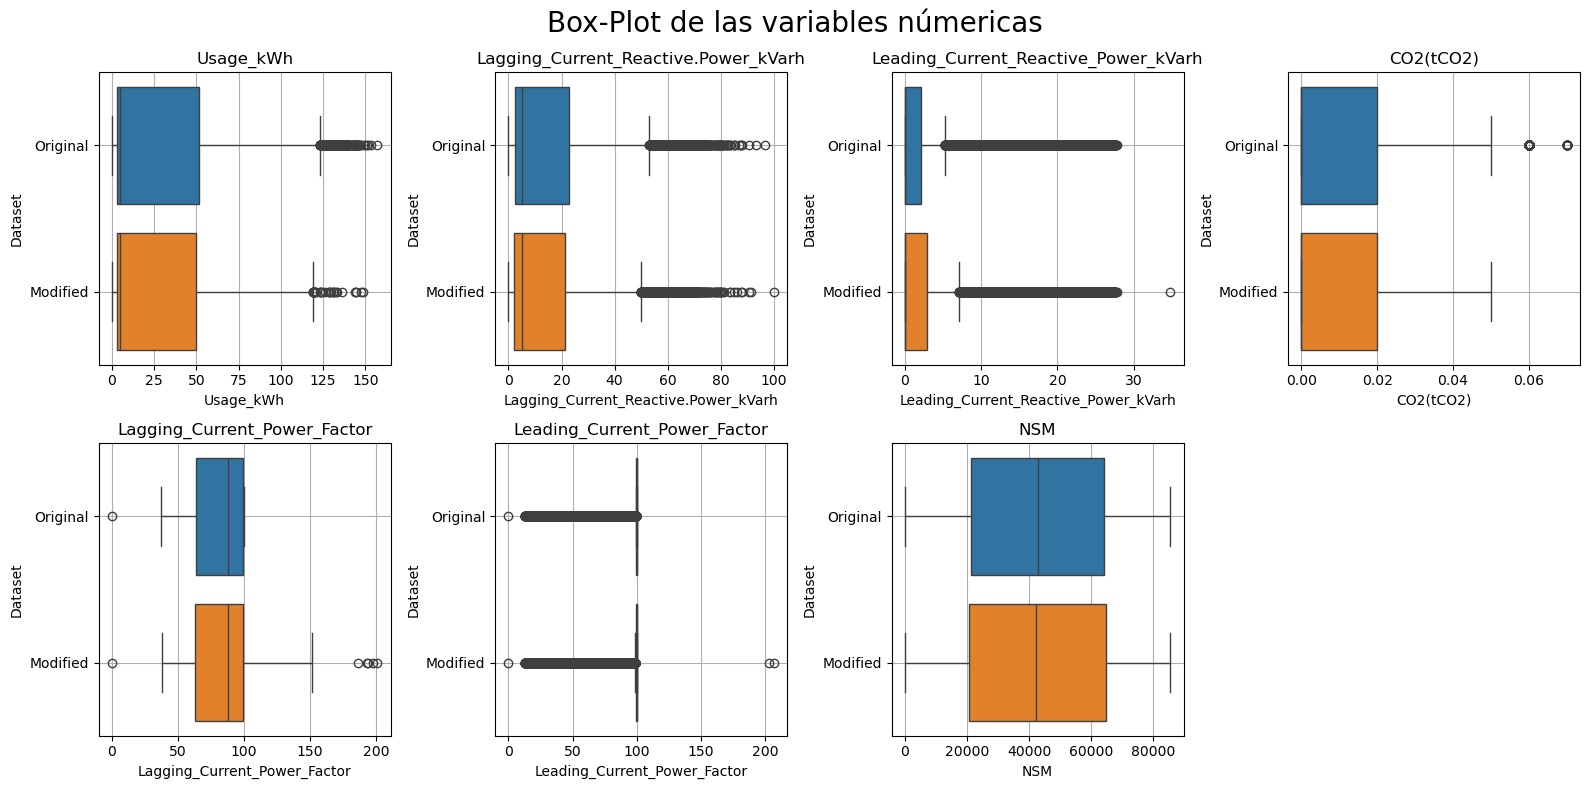

In [35]:
boxplots(combined_df2, n_cols=4, figsize_per_plot=(4, 4), y = 'Dataset', hue = 'Dataset')

Podemos ver de forma visual como ambas distribuciones, con los datos originales y ya los datos limpios y transformados, que se asemejan mucho más, con lo que, podemos estar seguros que el conjunto de datos modificado ya esta limpio y listo para el modelado, sin embargo podemos hacer un análisis más riguroso y cuantitativo para comparar ambas distribuciones para lo cual usaremos la distancia de Wasserstein y la distancia de Jensen-Shannon para medir estas distancias entre ambas distribuciones


La divergencia de Jensen-Shannon es una medida de similitud entre dos distribuciones de probabilidad P y Q. Se define como

$$D_{JS} (P||q) = \frac{1}{2} D_{KL} (P || M) + \frac{1}{2} D_{KL} (Q || M)$$

donde 
$$M = \frac{1}{2} (P + Q)$$

y D_KL es la divergencia de Kullback-Leibler, que mide la diferencia entre dos distribuciones de probabilidad. Toma valores entre 0 y 1, donde 0 indica que las distribuciones son idénticas y 1 indica que son completamente diferentes.

Por otra parte la distancia de Wasserstein, puede entenderse como el coste de un plan de transporte óptimo para convertir una distribución en la otra. El coste se calcula como el producto de la masa de probabilidad que se mueve por la distancia recorrida

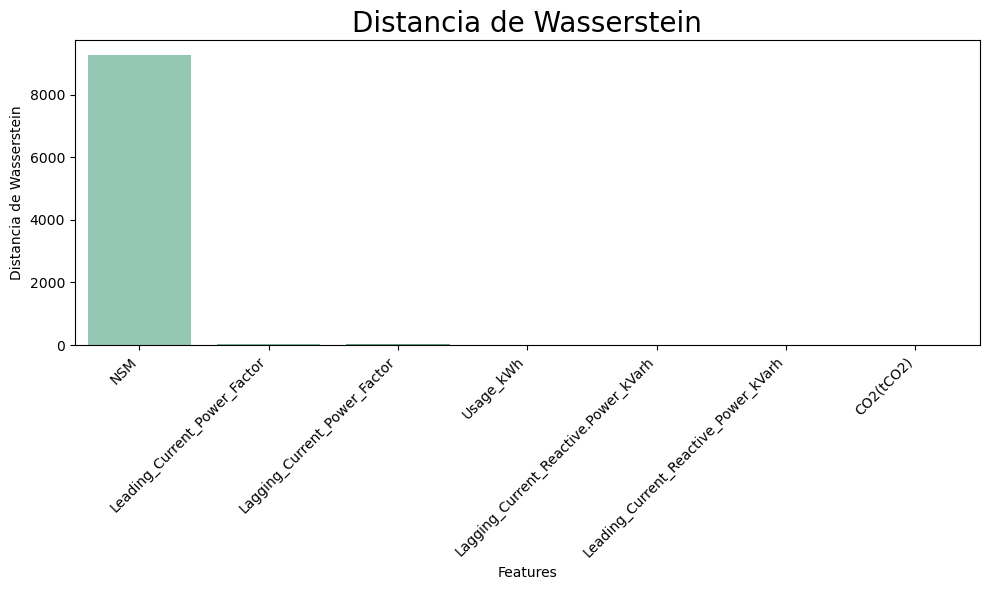

,Wasserstein Distance
NSM,9271.238242
Leading_Current_Power_Factor,24.429953
Lagging_Current_Power_Factor,21.007112
Usage_kWh,11.685052
Lagging_Current_Reactive.Power_kVarh,5.891226
Leading_Current_Reactive_Power_kVarh,3.774827
CO2(tCO2),2.610527


In [36]:
wassertein_comparison(combined_df, dt1_name = 'Original', dt2_name = 'Modified', hue_col='Dataset')

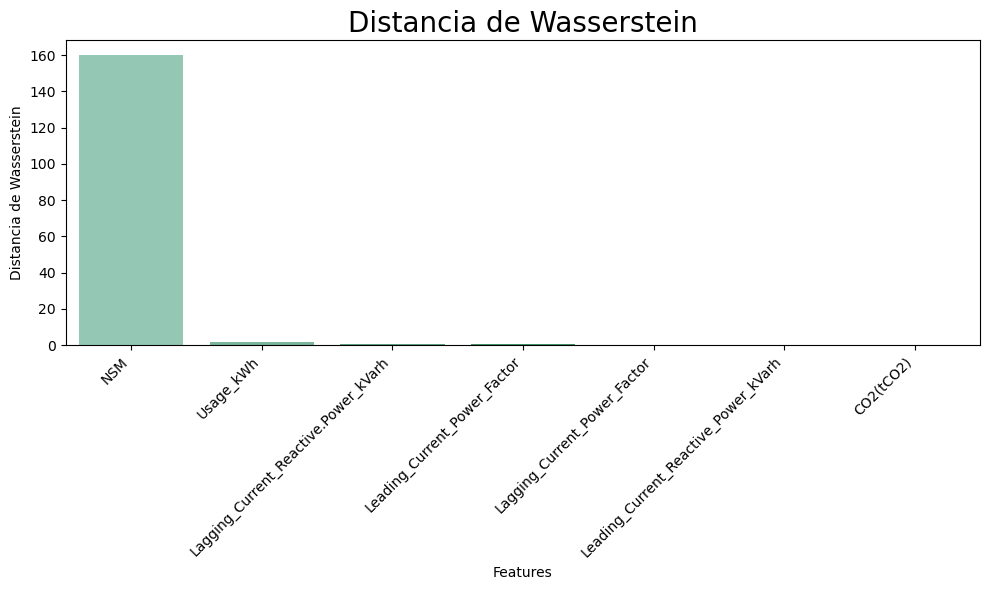

,Wasserstein Distance
NSM,160.115581
Usage_kWh,1.399162
Lagging_Current_Reactive.Power_kVarh,0.662277
Leading_Current_Power_Factor,0.400833
Lagging_Current_Power_Factor,0.237062
Leading_Current_Reactive_Power_kVarh,0.103791
CO2(tCO2),0.000729


In [37]:
wassertein_comparison(combined_df2, dt1_name = 'Original', dt2_name = 'Modified', hue_col='Dataset')

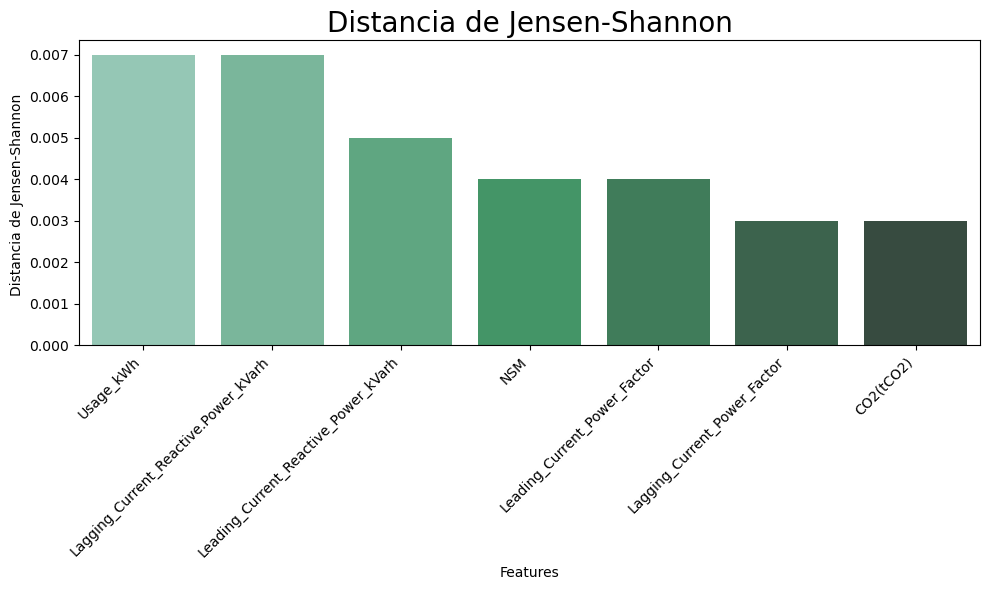

,Distancia de Jensen-Shannon
Usage_kWh,0.007
Lagging_Current_Reactive.Power_kVarh,0.007
Leading_Current_Reactive_Power_kVarh,0.005
NSM,0.004
Leading_Current_Power_Factor,0.004
Lagging_Current_Power_Factor,0.003
CO2(tCO2),0.003


In [38]:
jensen_shannon_comparison(combined_df, dt1_name = 'Original', dt2_name = 'Modified', hue_col='Dataset', bins=30)

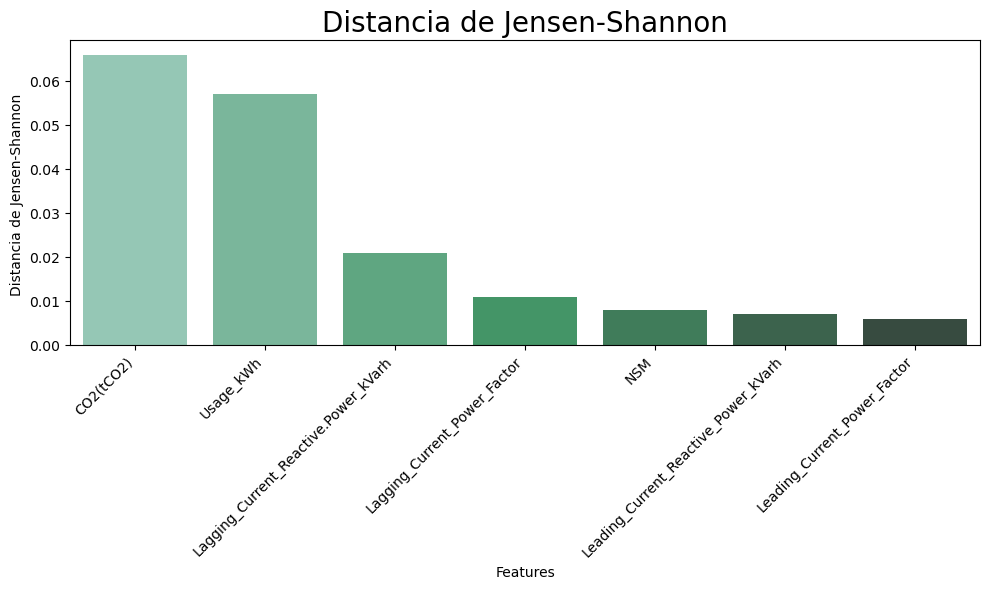

,Distancia de Jensen-Shannon
CO2(tCO2),0.066
Usage_kWh,0.057
Lagging_Current_Reactive.Power_kVarh,0.021
Lagging_Current_Power_Factor,0.011
NSM,0.008
Leading_Current_Reactive_Power_kVarh,0.007
Leading_Current_Power_Factor,0.006


In [39]:
jensen_shannon_comparison(combined_df2, dt1_name = 'Original', dt2_name = 'Modified', hue_col='Dataset', bins=30)

Como podemos ver en las gráficas, logramos reducir la distancia de Wasserstein (se puede observar que para el caso de NSM, es el campo que tiene la mayor diferencia, misma que se ve reflejada en la comparación de la gráfica de KDE), lo que refleja que nuestras distribuciones son más similaers, sin embargo la distancia de Jensen-Shannon se incrementó un poco, a pesar de ello, ambas distancias son bajas, lo que refleja que las distribuciones son similares y que el conjunto de datos modificado ya esta limpio y listo para el modelado.

In [40]:
# Retención de datos
f'{round((len(df4)/len(df))*100,2)} % de los datos originales permanecieron después de eliminar los outliers'

'80.82 % de los datos originales permanecieron después de eliminar los outliers'

Después de la limpieza de los datos y del mapeado podemos ahora si, ver el comportamiento de las variables y ver si encontramos relaciones interesantes entre estas

In [41]:
df4.describe(include='object').T

,count,unique,top,freq
WeekStatus,28886,2,Weekday,20474
Day_of_week,28886,7,Saturday,4211
Load_Type,28886,3,Light_Load,15097
Dataset,28886,1,Modified,28886


In [42]:
# Comprobación de que no existan valores faltantes
missing_percentage(df4)

date                                    0.0
Usage_kWh                               0.0
Lagging_Current_Reactive.Power_kVarh    0.0
Leading_Current_Reactive_Power_kVarh    0.0
CO2(tCO2)                               0.0
Lagging_Current_Power_Factor            0.0
Leading_Current_Power_Factor            0.0
NSM                                     0.0
WeekStatus                              0.0
Day_of_week                             0.0
Load_Type                               0.0
Dataset                                 0.0
dtype: float64

In [43]:
# Guardar el DataFrame limpio en un nuevo archivo CSV
save_df_to_csv(df4, 'data/processed/steel_energy_modified_clean.csv', date_cols=["date"])

✅ DataFrame guardado exitosamente en: data/processed/steel_energy_modified_clean.csv


# Relaciones entre las variables

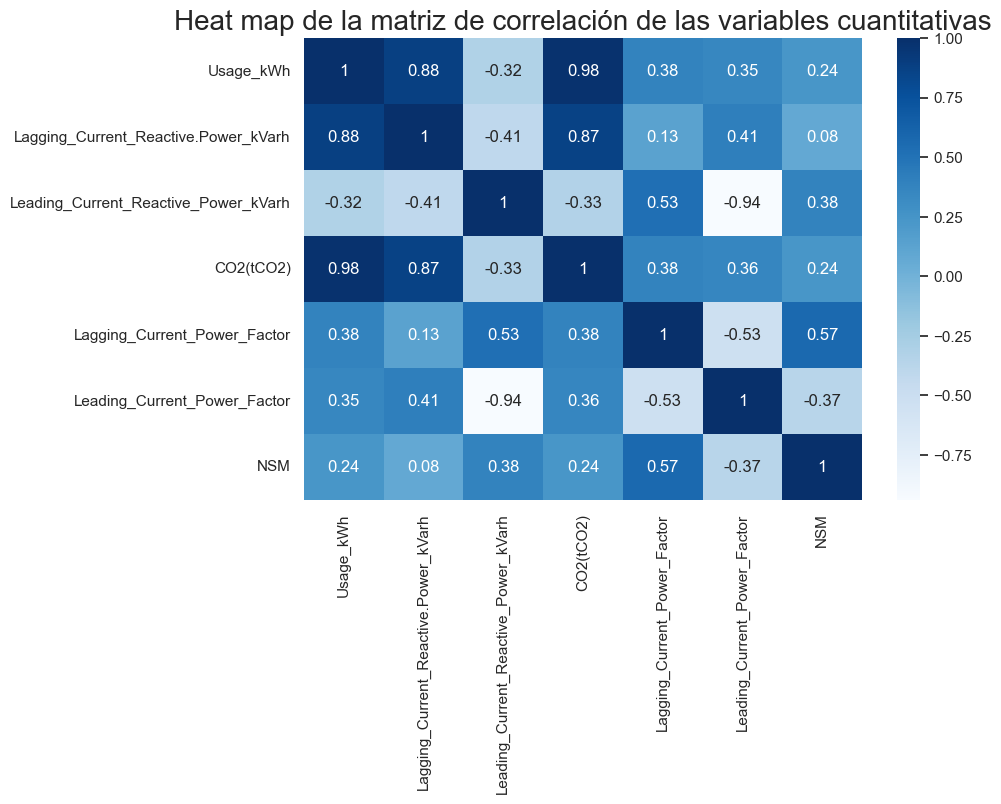

In [44]:
# Heatmpap de la matriz de correlación
sns.set(rc={'figure.figsize':(9,6)})

plt.title('Heat map de la matriz de correlación de las variables cuantitativas', fontsize = 20)
sns.heatmap(df4[numeric_cols].corr().round(2), cmap= 'Blues',annot=True)

plt.show()

Podemos ver que existen variables que tienen mucha correlación entre si, como por ejemplo CO2t con Usage_kWh, por otra parte presenta una gran correlación negativa el Leading_Current_Power_Factor con el Leaddint_Current_Reactive_Power_kVarth, por lo que se puede buscar eliminar alguna de estas variables para evitar la multicolinealidad en los modelos.

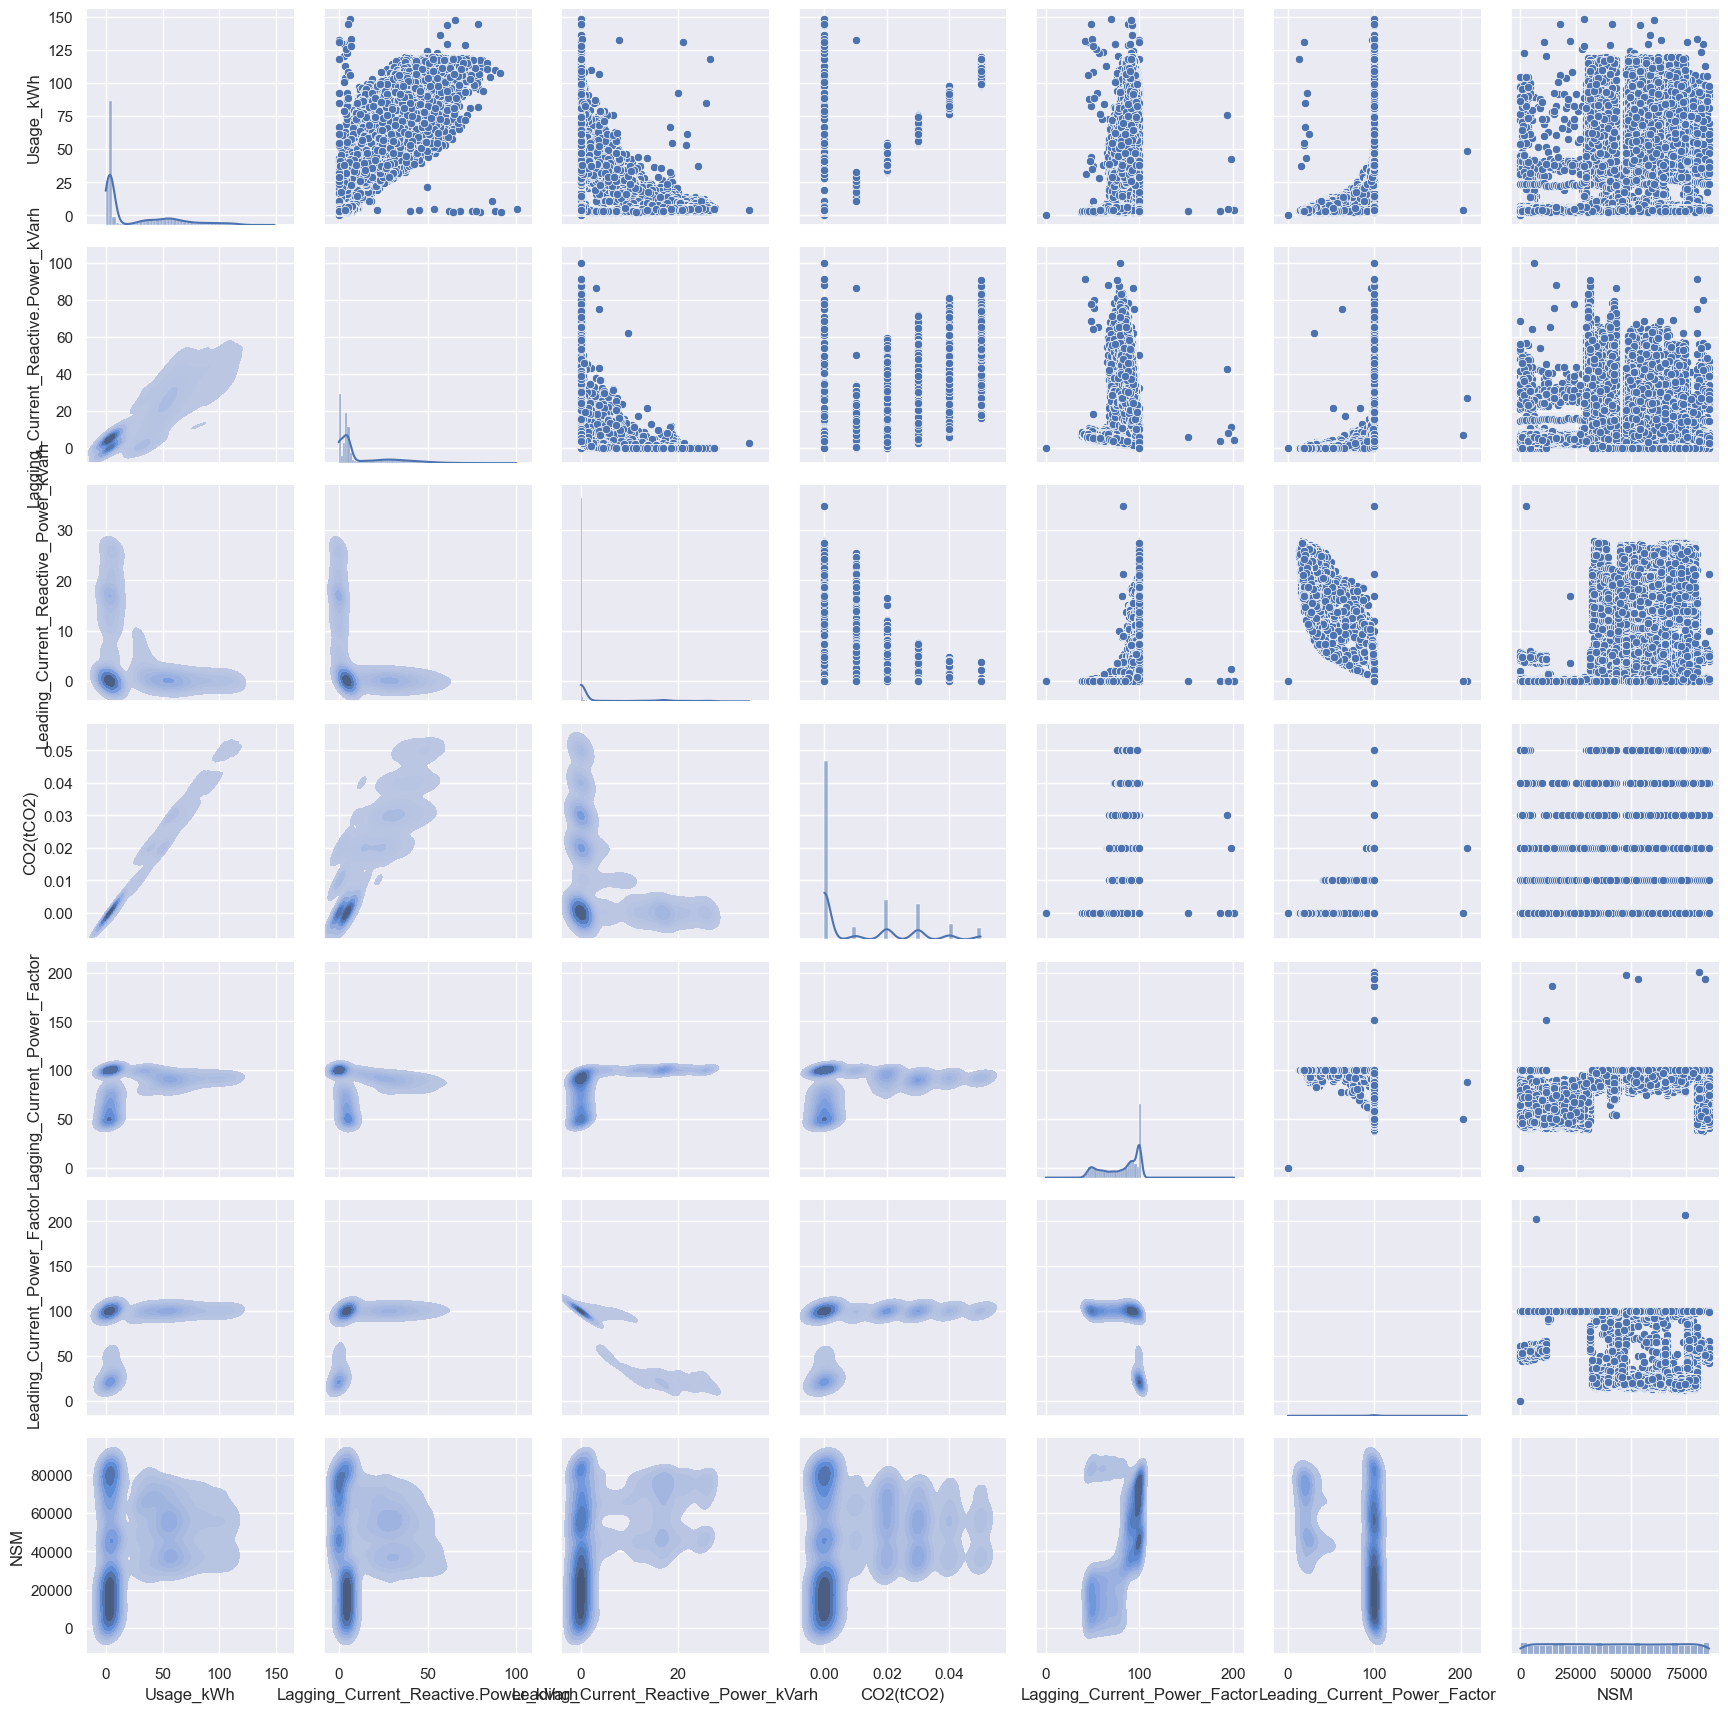

In [45]:
g = sns.PairGrid(df4)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

# Comparaciónd de las variables con el uso de kWh

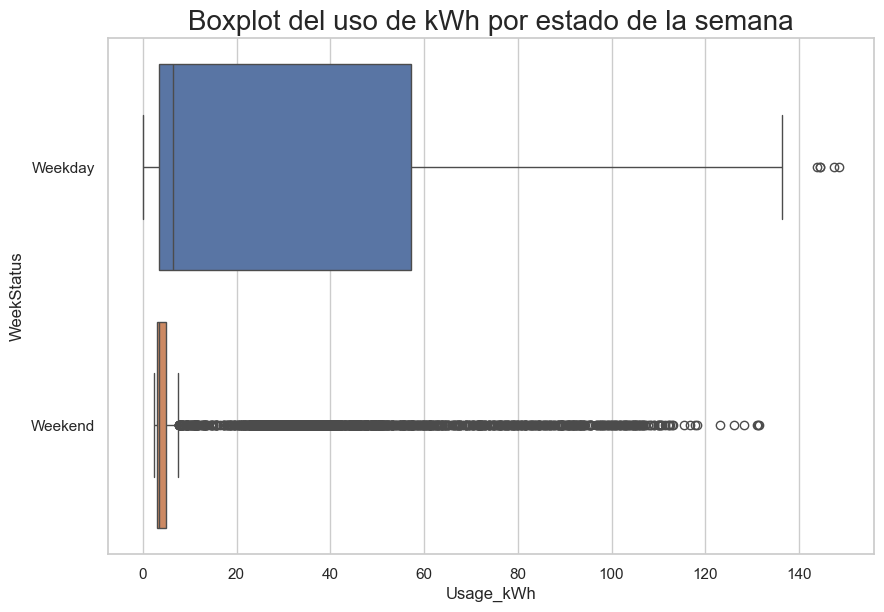

In [46]:
sns.set_style("whitegrid") 
sns.boxplot(data=df4, x='Usage_kWh', y = 'WeekStatus', hue = 'WeekStatus')
plt.tight_layout()
plt.title('Boxplot del uso de kWh por estado de la semana', fontsize = 20);

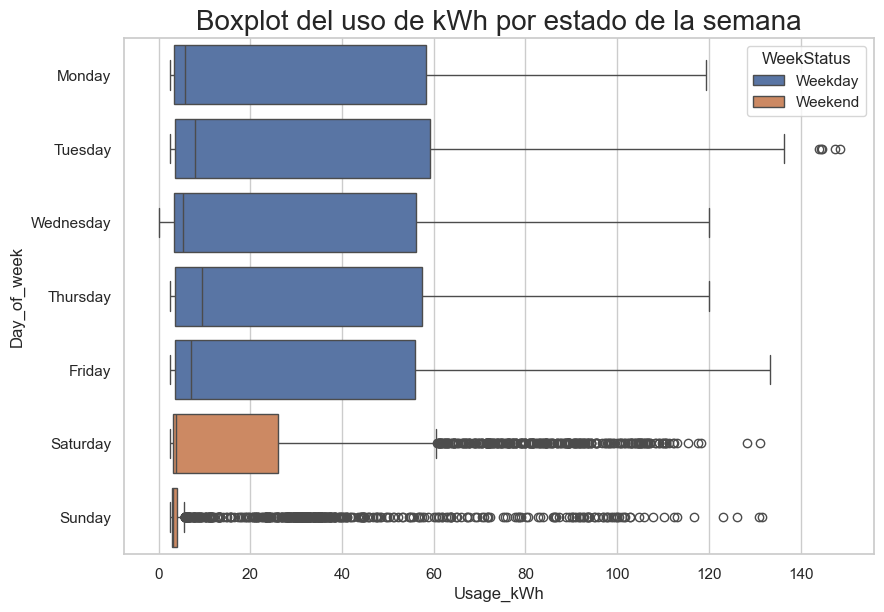

In [47]:
sns.set_style("whitegrid") 
sns.boxplot(data=df4, x='Usage_kWh', y = 'Day_of_week', hue = 'WeekStatus')
plt.tight_layout()
plt.title('Boxplot del uso de kWh por estado de la semana', fontsize = 20);

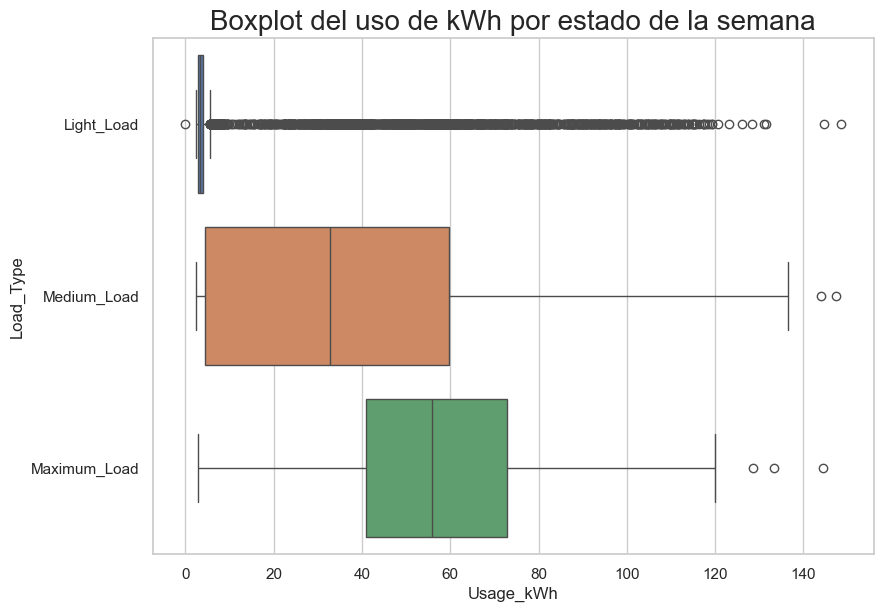

In [48]:
sns.set_style("whitegrid") 
sns.boxplot(data=df4, x='Usage_kWh', y = 'Load_Type', hue = 'Load_Type')
plt.tight_layout()
plt.title('Boxplot del uso de kWh por estado de la semana', fontsize = 20);

# Analisis de la serie de tiempo

Los datos son de un año de operaciones, por lo que podemos observar el comportamiento de la serie de tiempo a lo largo del año, así como observar si existen patrones estacionales o tendencias en los datos, dado que no tenemos más de un año, sin embargo, no podríamos tener la certeza para extrapolar patrones dentro de los meses

In [49]:
# Conversion a datetime
df4.loc[:,'date'] = pd.to_datetime(df4['date'])

# Extraer mes, día y hora
df4.loc[:,'month'] = df4['date'].dt.month
df4.loc[:,'day'] = df4['date'].dt.day
df4.loc[:,'hour'] = df4['date'].dt.hour


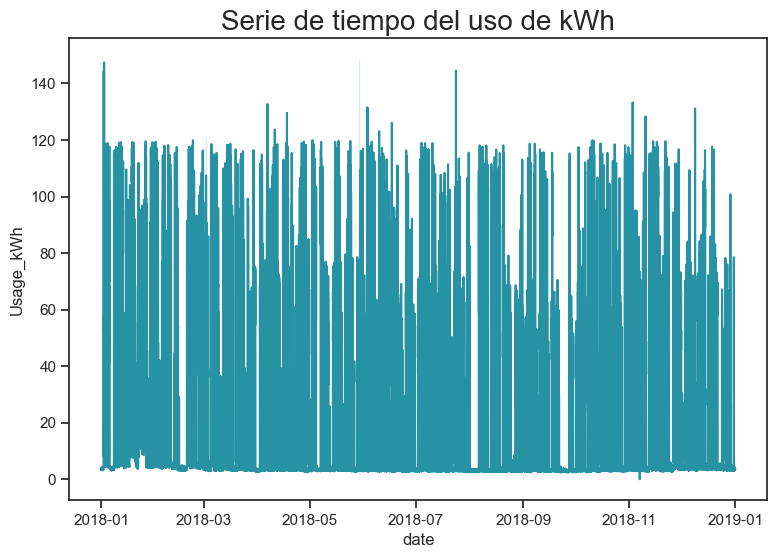

In [50]:
sns.set_theme(style="ticks")
sns.lineplot(data=df4, x='date', y='Usage_kWh', color= '#2692A3')
plt.title('Serie de tiempo del uso de kWh', fontsize = 20);

Debido a la gran cantidad de datos, no se puede observar una patrón claro dentro del consumo de energía, por ello  vamos a observar el gasto de los primeros 15 días del año para entender mejor el comportamiento de la serie de tiempo

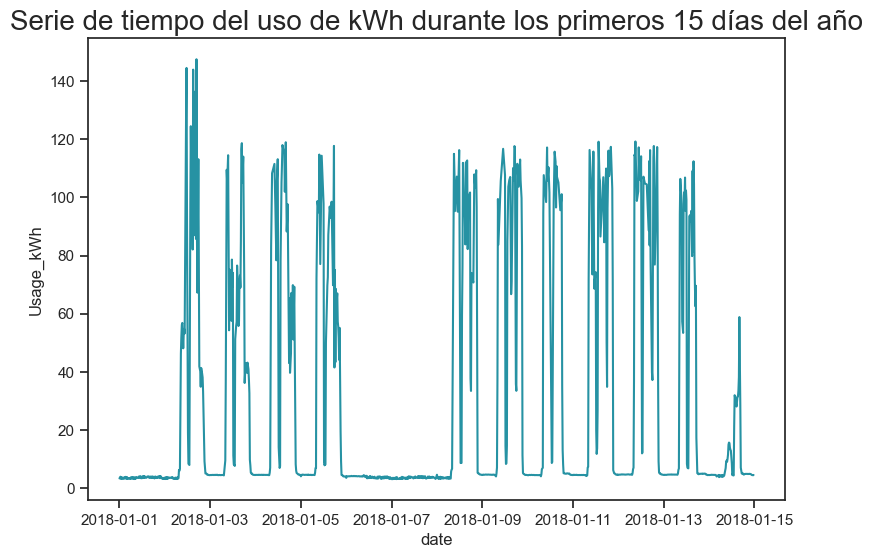

In [51]:
sns.set_theme(style="ticks")
sns.lineplot(data=df4[(df4['day'] >= 1) & (df4['day'] <= 14) & (df4['month'] == 1)], x='date', y='Usage_kWh', color = '#2692A3')
plt.title('Serie de tiempo del uso de kWh durante los primeros 15 días del año', fontsize = 20);

Con un conjunto menor de datos podemos observar mejor el comportamiento de la serie de tiempo,pero habrá que ver si ese patrón se mantiene a lo largo del año.

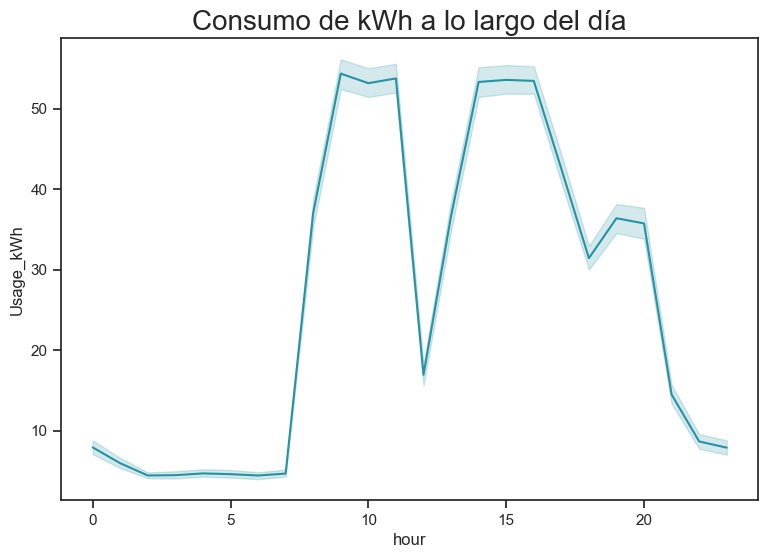

In [52]:
sns.lineplot(data=df4, x='hour', y='Usage_kWh', color = '#2692A3');
plt.title('Consumo de kWh a lo largo del día', fontsize = 20);

 En al gráfica se muestran patrones a lo largo del día, con picos de consumo alrededor de media mañana, seguido de una caída en el consumo alrededor del mediodía, seguido de un aumento en la tarde y una caída en la noche. Esto sugiere que el consumo de energía está relacionado con las horas de trabajo y las actividades diarias en la planta de acero así como posiblemente por los horarios de operación de la planta. También observamos que no hay una gran desviación respecto a la media

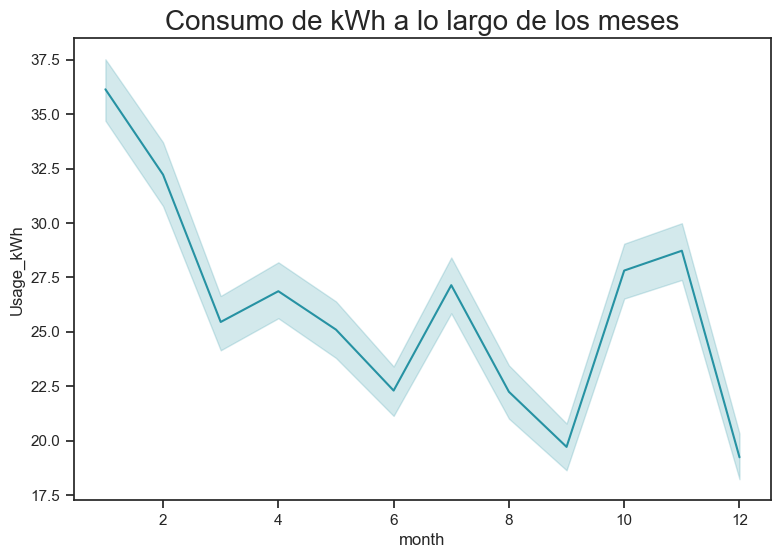

In [53]:
sns.lineplot(data=df4, x='month', y='Usage_kWh', color = '#2692A3');
plt.title('Consumo de kWh a lo largo de los meses', fontsize = 20);

Algo que no se observa con demasiada claridad dentro de la gráfica original es si a lo largo del año hay una patrón de estacionalidad, como se observa en la gráfica anterior, se observa una caída en cuanto al conusmo a lo largo del año, principalmente en los meses de verano, con un repunte en otoño-invierno

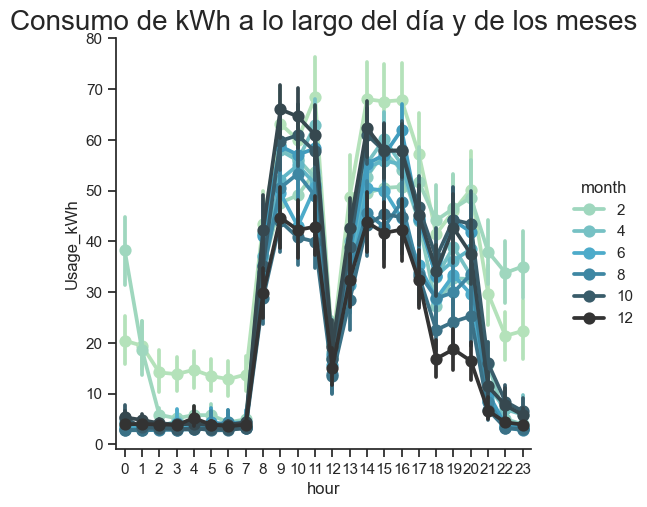

In [54]:
sns.catplot(data=df4, x='hour', y='Usage_kWh', hue= 'month', palette = 'GnBu_d', kind = 'point')
plt.title('Consumo de kWh a lo largo del día y de los meses', fontsize = 20);

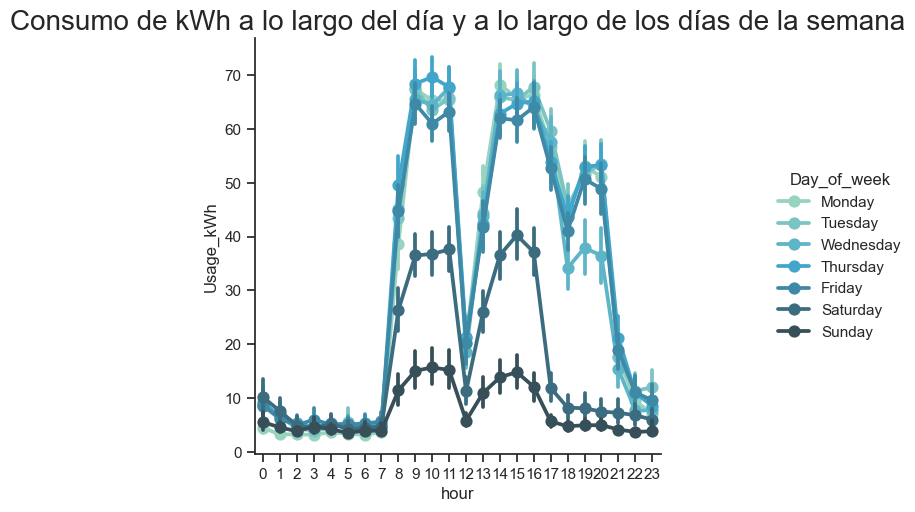

In [55]:
sns.catplot(data=df4, x='hour', y='Usage_kWh', hue='Day_of_week', kind='point', palette='GnBu_d')
plt.title('Consumo de kWh a lo largo del día y a lo largo de los días de la semana', fontsize = 20);

Combinando ambos efectos podemos observar que el consumo de energía tiene un patrón diario claro, con picos de consumo en horas específicas del día, y también muestra como va variando a lo largo del año, cayendo el consumo conforme progresan los meses, de igual forma podemos observar como se mantiene el mismo patrón diaro a lo largo de los días de la semana, manteniendose el patrón diaro aunque ajustado a los patrones de consumo de la semana, como paarticularidad sabado y domingo no presentan el pico de media tarde-noche, posiblemente debido a un horario ajustado esos días y esas horas

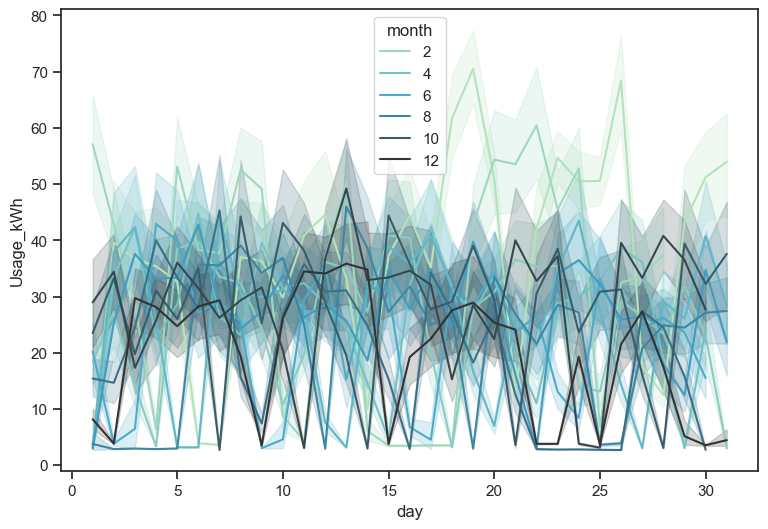

In [56]:
sns.lineplot(data=df4, x='day', y='Usage_kWh', hue = 'month', palette = 'GnBu_d');

Viendo las gráficas de los días del mes y a lo largo del mes, por otra parte no se logra detectar un patrón claro, por lo que puede estar más influenciado por los otros factores como los días de la semana y las horas del día, más allá que del día del mes

# Codificación de las variables categóricas

In [57]:
df5 = df4.copy()

In [58]:
df5.tail(2)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Dataset,month,day,hour
35737,2018-02-20 04:30:00,5.83,5.22,0.0,0.0,74.50,100.0,16200,Weekday,Tuesday,Light_Load,Modified,2,20,4
35739,2018-02-11 22:30:00,3.64,3.53,0.0,0.0,71.79,100.0,81000,Weekend,Sunday,Light_Load,Modified,2,11,22


In [59]:
# Split en el conjunto de entrenamiento y prueba
X = df5.drop('Usage_kWh', axis=1)
y = df5['Usage_kWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (23108, 14) (23108,)
Testing set shape: (5778, 14) (5778,)


In [60]:
# Transformación de datos
pre = ColumnTransformer(
    transformers=[
        ('numeric_cols', Pipeline([
            ('Standard_Scaler', StandardScaler())
        ]), ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']),
        ('Day_of_week_oh', Pipeline([
            ('ohe', OneHotEncoder(
              categories=[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']],
              drop='first',
              sparse_output=False))
        ]), ['Day_of_week']),
        ('WeekStatus_bi', Pipeline([ # produce 1 col: Weekend=0, Weekday=1
            ('bin', OneHotEncoder(
                categories=[['Weekend', 'Weekday']],
                drop='first',
                sparse_output=False
              ))
        ]), ['WeekStatus']),
        ('LoadType_ord', Pipeline([
            ('ord', OrdinalEncoder(
                categories=[['Light_Load','Medium_Load','Maximum_Load']],
                dtype=np.int8,
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ))
        ]), ['Load_Type'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [61]:
df5[['Day_of_week', 'WeekStatus', 'Load_Type']].tail(5)

,Day_of_week,WeekStatus,Load_Type
35734,Sunday,Weekend,Light_Load
35735,Wednesday,Weekday,Light_Load
35736,Sunday,Weekend,Light_Load
35737,Tuesday,Weekday,Light_Load
35739,Sunday,Weekend,Light_Load


In [62]:
# Apply the ColumnTransformer to a sample of the data
transformed_data = pre.fit_transform(df5[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'Day_of_week', 'WeekStatus', 'Load_Type']].tail(5))

# Display the transformed data
display(transformed_data)

array([[-1.88697429,  2.        ,  0.        ,  1.83349617, -2.        ,
         1.12206536,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.77073598, -0.5       ,  0.        , -1.20164384,  0.5       ,
        -0.91305319,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.23919392, -0.5       ,  0.        , -0.37732989,  0.5       ,
        -0.85804998,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.88767523, -0.5       ,  0.        , -0.02832895,  0.5       ,
        -0.66553877,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [-0.01063084, -0.5       ,  0.        , -0.2261935 ,  0.5       ,
         1.31457658,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.  